<a href="https://colab.research.google.com/github/eedduu/TFG/blob/main/code/old_playgrounds/Pruebas_TFG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Prerrequisitos para usar FastAI
#!pip install -Uqq fastbook
!pip install nbdev
!pip install fastai
#import fastbook
#fastbook.setup_book()
import fastai
import fastcore
print(f'fastcore version {fastcore.__version__} installed')
print(f'fastai version {fastai.__version__} installed')
from nbdev.showdoc import *
from fastai.vision.all import *
import torch.nn.functional as F
import torchvision.transforms.functional as FF
import numpy
import torchvision
from torchvision import *

from sklearn.model_selection import StratifiedKFold
!pip install google
#from google.colab import drive

fastcore version 1.5.29 installed
fastai version 2.7.12 installed


In [ ]:
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/TFG_models

Mounted at /content/gdrive
/content/gdrive/MyDrive/TFG_models


In [ ]:
# Función para printar las gráficas de entrenamiento
# Developed by Ignacio Oguiza: https://forums.fast.ai/t/plotting-metrics-after-learning/69937

@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

In [ ]:
#Defino la red neuronal LeNet-5, como una función para poder reutilizarla fácilmente sin tener que restablecer los pesos
def LeNet5():
    return nn.Sequential(
    nn.Conv2d(1,6,kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(6,16,kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(400,120),
    nn.ReLU(),
    nn.Linear(120,84),
    nn.ReLU()
)

In [ ]:
def LeNet52():
    return nn.Sequential(
    nn.Conv2d(1,6,kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(6,16,kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(400,120),
    nn.ReLU(),
    nn.Linear(120,100),
    nn.ReLU()
)

Uso el Dataset MNIST, de clasificación de imágenes de dígitos manuscritos, es un dataset sencillo. (http://yann.lecun.com/exdb/mnist/). Lo implemento desde la API de FastAI por comodidad de uso. Vemos también cómo vienen presentados los datos.

In [ ]:
#Cargo el dataset que voy a usar.
path = untar_data(URLs.MNIST)
print(path.ls())

[Path('/home/edu/.fastai/data/mnist_png/testing'), Path('/home/edu/.fastai/data/mnist_png/training')]


In [ ]:
####Prueba 5-folds
train_imgs= get_image_files(path/'training')
test_imgs= get_image_files(path/'testing')

# GRID SEARCH FOR MINI BATCH SGD

In [ ]:
###Prueba Grid Search for lr MB SGD




lrs=[0.1,0.01,0.001]
for lr in lrs:
  kf = StratifiedKFold(n_splits=3, shuffle=True)
  item_tfms = [ToTensor(), Resize(32)]
  batch_tfms = [IntToFloatTensor()]
  dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImageBW.create], [parent_label, Categorize]])
  dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)

  train_labels=L(dls.train_ds.items).map(dls.tfms[1])

  i=0
  learners=[]
  for _, val_idx in kf.split(np.array(train_imgs+test_imgs), train_labels):
    i+=1
    splits = IndexSplitter(val_idx)
    split = splits(train_imgs+test_imgs)
    split_list = [split[0], split[1]]
    #split_list.append(L(range(len(train_imgs), len(train_imgs)+len(test_imgs))))
    dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImageBW.create], [parent_label, Categorize]],
                    splits=split_list)
    dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)



    print("Model {}::::::::::::::::::::::: con lr {}".format(i,lr))
    model=LeNet5()
    learn=Learner(dls,model,loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=SGD)
    learn.fit(2, lr=lr)
    learners.append(learn)


Model 1::::::::::::::::::::::: con lr 0.1


epoch,train_loss,valid_loss,accuracy,time
0,0.098361,0.087557,0.972058,01:44
1,0.060579,0.066120,0.979515,01:44


Model 2::::::::::::::::::::::: con lr 0.1


epoch,train_loss,valid_loss,accuracy,time
0,0.100450,0.099171,0.969100,01:42
1,0.061202,0.059647,0.981828,01:41


Model 3::::::::::::::::::::::: con lr 0.1


epoch,train_loss,valid_loss,accuracy,time
0,0.076513,0.080339,0.974285,01:44
1,0.059489,0.075254,0.974971,01:43


Model 1::::::::::::::::::::::: con lr 0.01


epoch,train_loss,valid_loss,accuracy,time
0,0.313513,0.305521,0.908074,01:42
1,0.177045,0.191212,0.940002,01:42


Model 2::::::::::::::::::::::: con lr 0.01


epoch,train_loss,valid_loss,accuracy,time
0,0.298319,0.304714,0.902070,01:43
1,0.154740,0.152104,0.953456,01:44


Model 3::::::::::::::::::::::: con lr 0.01


epoch,train_loss,valid_loss,accuracy,time
0,0.323922,0.296173,0.910213,01:40
1,0.157426,0.166291,0.950028,01:45


Model 1::::::::::::::::::::::: con lr 0.001


epoch,train_loss,valid_loss,accuracy,time
0,2.983347,2.757359,0.106026,01:44
1,1.681910,1.630109,0.695123,01:42


Model 2::::::::::::::::::::::: con lr 0.001


epoch,train_loss,valid_loss,accuracy,time
0,3.396337,3.243784,0.158445,01:43
1,2.285282,2.271348,0.605794,01:44


Model 3::::::::::::::::::::::: con lr 0.001


epoch,train_loss,valid_loss,accuracy,time
0,4.395370,4.391074,0.102344,02:03
1,3.832849,3.835512,0.103587,01:47


#CROSS VAL MB SGD W LR FROM GRID SEARCH

In [ ]:
#Cross Val MB SGD


kf = StratifiedKFold(n_splits=5, shuffle=True)
item_tfms = [ToTensor(), Resize(32)]
batch_tfms = [IntToFloatTensor()]
dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImageBW.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)

train_labels=L(dls.train_ds.items).map(dls.tfms[1])

i=0
learners=[]
lr=0.1
for _, val_idx in kf.split(np.array(train_imgs+test_imgs), train_labels):
  i+=1
  splits = IndexSplitter(val_idx)
  split = splits(train_imgs+test_imgs)
  split_list = [split[0], split[1]]
  #split_list.append(L(range(len(train_imgs), len(train_imgs)+len(test_imgs))))
  dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImageBW.create], [parent_label, Categorize]],
                  splits=split_list)
  dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)



  print("Model {}:::::::::::::::::::::::".format(i))
  model=LeNet5()
  learn=Learner(dls,model,loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=SGD)
  learn.fit(8, lr=lr, cbs=[SaveModelCallback()])
  learners.append(learn)




Model 1:::::::::::::::::::::::


epoch,train_loss,valid_loss,accuracy,time
0,0.471807,0.470182,0.891929,01:37
1,0.435636,0.455246,0.894500,01:33
2,0.431746,0.453810,0.897214,01:34
3,0.430716,0.445183,0.897929,01:33
4,0.404215,0.448575,0.898857,01:33
5,0.360654,0.443553,0.898714,01:37
6,0.400065,0.443009,0.900071,01:35
7,0.389102,0.440811,0.900857,01:35


Better model found at epoch 0 with valid_loss value: 0.47018229961395264.
Better model found at epoch 1 with valid_loss value: 0.45524635910987854.
Better model found at epoch 2 with valid_loss value: 0.45380955934524536.
Better model found at epoch 3 with valid_loss value: 0.4451826810836792.
Better model found at epoch 5 with valid_loss value: 0.44355306029319763.
Better model found at epoch 6 with valid_loss value: 0.4430088996887207.
Better model found at epoch 7 with valid_loss value: 0.4408110976219177.
Model 2:::::::::::::::::::::::


epoch,train_loss,valid_loss,accuracy,time
0,0.076534,0.072538,0.977857,01:35
1,0.051652,0.061542,0.981071,01:36
2,0.033612,0.045601,0.986071,01:37
3,0.025980,0.046948,0.985857,01:36
4,0.025581,0.048061,0.986357,01:36
5,0.026922,0.039340,0.988214,01:35
6,0.016912,0.059332,0.984000,01:35
7,0.016750,0.040375,0.988429,01:35


Better model found at epoch 0 with valid_loss value: 0.07253776490688324.
Better model found at epoch 1 with valid_loss value: 0.061542388051748276.
Better model found at epoch 2 with valid_loss value: 0.045601360499858856.
Better model found at epoch 5 with valid_loss value: 0.03934004157781601.
Model 3:::::::::::::::::::::::


epoch,train_loss,valid_loss,accuracy,time
0,0.070385,0.070937,0.978429,01:35
1,0.058155,0.055369,0.983143,01:34
2,0.043782,0.043934,0.986714,01:33
3,0.034371,0.046890,0.986214,01:33
4,0.024799,0.045774,0.985786,01:33
5,0.023122,0.035959,0.989929,01:34
6,0.023752,0.038128,0.988643,01:34
7,0.016859,0.040694,0.988786,01:35


Better model found at epoch 0 with valid_loss value: 0.07093708217144012.
Better model found at epoch 1 with valid_loss value: 0.05536920577287674.
Better model found at epoch 2 with valid_loss value: 0.043934185057878494.
Better model found at epoch 5 with valid_loss value: 0.035959258675575256.
Model 4:::::::::::::::::::::::


epoch,train_loss,valid_loss,accuracy,time
0,0.087693,0.082729,0.972357,01:33
1,0.055149,0.051985,0.983286,01:33
2,0.051893,0.045413,0.985929,01:34
3,0.036266,0.057033,0.981929,01:33
4,0.030175,0.044106,0.986643,01:34
5,0.023246,0.057407,0.983214,01:33
6,0.021169,0.041002,0.988357,01:34
7,0.014065,0.042541,0.988214,01:34


Better model found at epoch 0 with valid_loss value: 0.08272916078567505.
Better model found at epoch 1 with valid_loss value: 0.051984868943691254.
Better model found at epoch 2 with valid_loss value: 0.045412737876176834.
Better model found at epoch 4 with valid_loss value: 0.04410595819354057.
Better model found at epoch 6 with valid_loss value: 0.04100155085325241.
Model 5:::::::::::::::::::::::


epoch,train_loss,valid_loss,accuracy,time
0,0.065614,0.075574,0.977429,01:33
1,0.060082,0.052093,0.984571,01:33
2,0.051400,0.055505,0.982429,01:33
3,0.043228,0.047073,0.985143,01:34
4,0.021707,0.043729,0.988071,01:35
5,0.023342,0.046766,0.985929,01:34
6,0.018401,0.038430,0.989000,01:35
7,0.014577,0.038326,0.989429,01:34


Better model found at epoch 0 with valid_loss value: 0.07557407021522522.
Better model found at epoch 1 with valid_loss value: 0.05209330841898918.
Better model found at epoch 3 with valid_loss value: 0.04707331582903862.
Better model found at epoch 4 with valid_loss value: 0.04372892901301384.
Better model found at epoch 6 with valid_loss value: 0.03843042254447937.
Better model found at epoch 7 with valid_loss value: 0.038325805217027664.


#CROSS VAL MB SGD W LR LESLIE

Model 1:::::::::::::::::::::::


epoch,train_loss,valid_loss,accuracy,time
0,3.025089,3.031483,0.464429,04:48
1,0.418516,0.430673,0.861429,00:49
2,0.167665,0.159884,0.951643,00:55
3,0.102598,0.108639,0.965500,00:59
4,0.068106,0.083138,0.974000,01:00
5,0.051930,0.067605,0.977857,01:01
6,0.045151,0.062654,0.979500,01:01
7,0.043260,0.044546,0.986143,01:02
8,0.037469,0.042507,0.986500,01:03
9,0.028408,0.043823,0.985571,01:02


Better model found at epoch 0 with valid_loss value: 3.0314829349517822.
Better model found at epoch 1 with valid_loss value: 0.4306732416152954.
Better model found at epoch 2 with valid_loss value: 0.159883514046669.
Better model found at epoch 3 with valid_loss value: 0.10863909870386124.
Better model found at epoch 4 with valid_loss value: 0.0831383615732193.
Better model found at epoch 5 with valid_loss value: 0.06760530173778534.
Better model found at epoch 6 with valid_loss value: 0.06265351921319962.
Better model found at epoch 7 with valid_loss value: 0.04454565420746803.
Better model found at epoch 8 with valid_loss value: 0.04250723868608475.
Better model found at epoch 10 with valid_loss value: 0.039375193417072296.
Better model found at epoch 11 with valid_loss value: 0.038302600383758545.
No improvement since epoch 7: early stopping
Model 2:::::::::::::::::::::::


epoch,train_loss,valid_loss,accuracy,time
0,1.342526,1.321184,0.697071,01:30
1,0.159719,0.155880,0.951357,01:26
2,0.106734,0.098616,0.968500,01:25
3,0.072126,0.076749,0.975929,01:25
4,0.075983,0.073751,0.979643,01:24
5,0.041922,0.054893,0.983143,01:26
6,0.038080,0.046481,0.985286,01:27
7,0.029936,0.041554,0.988071,01:25
8,0.019983,0.048253,0.985643,01:26
9,0.019002,0.043060,0.988643,01:27


Better model found at epoch 0 with valid_loss value: 1.3211842775344849.
Better model found at epoch 1 with valid_loss value: 0.1558804214000702.
Better model found at epoch 2 with valid_loss value: 0.09861566126346588.
Better model found at epoch 3 with valid_loss value: 0.07674943655729294.
Better model found at epoch 4 with valid_loss value: 0.07375115156173706.
Better model found at epoch 5 with valid_loss value: 0.05489298701286316.
Better model found at epoch 6 with valid_loss value: 0.04648098349571228.
Better model found at epoch 7 with valid_loss value: 0.041553523391485214.
Better model found at epoch 10 with valid_loss value: 0.040123749524354935.
No improvement since epoch 7: early stopping
Model 3:::::::::::::::::::::::


epoch,train_loss,valid_loss,accuracy,time
0,0.211630,0.207071,0.935786,01:25
1,0.100621,0.094256,0.970357,01:25
2,0.083941,0.084193,0.973429,01:20
3,0.053242,0.060092,0.981143,01:23
4,0.036079,0.055707,0.983071,01:21
5,0.026052,0.043944,0.987214,01:21
6,0.031277,0.041466,0.988071,01:25
7,0.022293,0.040719,0.989429,01:24
8,0.023312,0.049715,0.987357,01:23
9,0.008456,0.041648,0.988714,01:22


Better model found at epoch 0 with valid_loss value: 0.2070707529783249.
Better model found at epoch 1 with valid_loss value: 0.09425601363182068.
Better model found at epoch 2 with valid_loss value: 0.0841926708817482.
Better model found at epoch 3 with valid_loss value: 0.06009233370423317.
Better model found at epoch 4 with valid_loss value: 0.055706970393657684.
Better model found at epoch 5 with valid_loss value: 0.04394372180104256.
Better model found at epoch 6 with valid_loss value: 0.041465673595666885.
Better model found at epoch 7 with valid_loss value: 0.040719255805015564.
No improvement since epoch 5: early stopping
Model 4:::::::::::::::::::::::


epoch,train_loss,valid_loss,accuracy,time
0,0.372228,0.329857,0.902429,01:21
1,0.141324,0.125626,0.962857,01:19
2,0.085596,0.076301,0.976643,01:22
3,0.069899,0.073883,0.976429,01:19
4,0.065674,0.055246,0.982714,01:23
5,0.052959,0.050574,0.984929,01:24
6,0.026569,0.047874,0.985071,01:24
7,0.027261,0.050756,0.985714,01:20
8,0.018873,0.045376,0.986929,01:24


Better model found at epoch 0 with valid_loss value: 0.3298574984073639.
Better model found at epoch 1 with valid_loss value: 0.12562623620033264.
Better model found at epoch 2 with valid_loss value: 0.07630107551813126.
Better model found at epoch 3 with valid_loss value: 0.07388267666101456.
Better model found at epoch 4 with valid_loss value: 0.055245671421289444.
Better model found at epoch 5 with valid_loss value: 0.050573643296957016.
Better model found at epoch 6 with valid_loss value: 0.047873590141534805.
Better model found at epoch 8 with valid_loss value: 0.04537561908364296.
No improvement since epoch 4: early stopping
Model 5:::::::::::::::::::::::


epoch,train_loss,valid_loss,accuracy,time
0,0.902219,0.923501,0.799143,01:23
1,0.195028,0.184170,0.944071,01:22
2,0.112156,0.101062,0.971429,01:30
3,0.066240,0.085384,0.973714,01:23
4,0.059432,0.077752,0.976071,01:23
5,0.047185,0.045443,0.986357,01:22
6,0.036767,0.062436,0.980714,01:25
7,0.038667,0.044143,0.987429,01:24
8,0.028768,0.040443,0.988071,01:26
9,0.022261,0.045434,0.986786,01:30


Better model found at epoch 0 with valid_loss value: 0.9235013127326965.
Better model found at epoch 1 with valid_loss value: 0.1841699331998825.
Better model found at epoch 2 with valid_loss value: 0.10106215626001358.
Better model found at epoch 3 with valid_loss value: 0.08538378775119781.
Better model found at epoch 4 with valid_loss value: 0.07775238901376724.
Better model found at epoch 5 with valid_loss value: 0.045443080365657806.
Better model found at epoch 7 with valid_loss value: 0.044143494218587875.
Better model found at epoch 8 with valid_loss value: 0.040443118661642075.
No improvement since epoch 5: early stopping


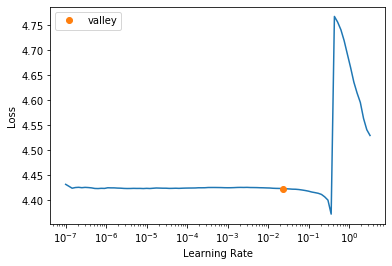

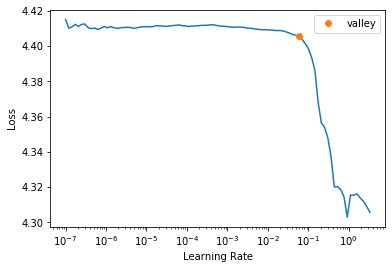

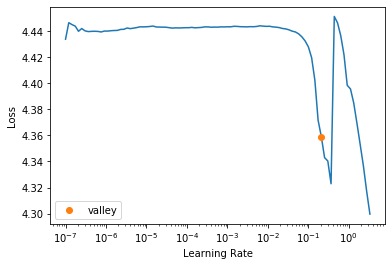

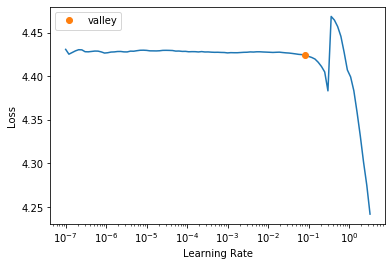

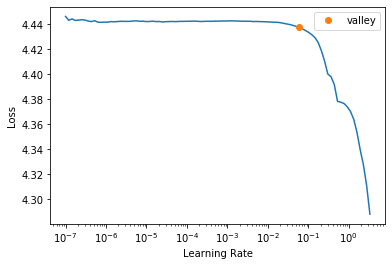

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True)
item_tfms = [ToTensor(), Resize(32)]
batch_tfms = [IntToFloatTensor()]
dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImageBW.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)

train_labels=L(dls.train_ds.items).map(dls.tfms[1])

i=0
learners=[]
lr=0.1
for _, val_idx in kf.split(np.array(train_imgs+test_imgs), train_labels):
  i+=1
  splits = IndexSplitter(val_idx)
  split = splits(train_imgs+test_imgs)
  split_list = [split[0], split[1]]
  #split_list.append(L(range(len(train_imgs), len(train_imgs)+len(test_imgs))))
  dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImageBW.create], [parent_label, Categorize]],
                  splits=split_list)
  dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)



  print("Model {}:::::::::::::::::::::::".format(i))
  model=LeNet5()
  learn=Learner(dls,model,loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=SGD)
  lr=learn.lr_find()
  learn.fit_one_cycle(20, lr_max=lr, cbs=[EarlyStoppingCallback(min_delta=0.01,patience=4), SaveModelCallback()])
  learners.append(learn)

#GRID SEARCH FOR LR PURE SGD

In [ ]:
#GridSearch for lr in SGD


lrs=[0.1,0.01,0.001]

kf = StratifiedKFold(n_splits=3, shuffle=True)
item_tfms = [ToTensor(), Resize(32)]
batch_tfms = [IntToFloatTensor()]
dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImageBW.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=1, after_item=item_tfms, after_batch=batch_tfms)

train_labels=L(dls.train_ds.items).map(dls.tfms[1])
for lr in lrs:

  i=0
  learners=[]
  for _, val_idx in kf.split(np.array(train_imgs+test_imgs), train_labels):
    i+=1
    splits = IndexSplitter(val_idx)
    split = splits(train_imgs+test_imgs)
    split_list = [split[0], split[1]]
    #split_list.append(L(range(len(train_imgs), len(train_imgs)+len(test_imgs))))
    dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImageBW.create], [parent_label, Categorize]],
                    splits=split_list)
    dls = dsrc.dataloaders(bs=1, after_item=item_tfms, after_batch=batch_tfms)



    print("Model {}::::::::::::::::::::::: con lr {}".format(i,lr))
    model=LeNet5()
    learn=Learner(dls,model,loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=SGD)
    learn.fit(2, lr=lr)
    learners.append(learn)

Model 1::::::::::::::::::::::: con lr 0.1


epoch,train_loss,valid_loss,accuracy,time
0,3.450575,3.321680,0.098226,07:53
1,3.277348,3.333311,0.104183,07:46


Model 2::::::::::::::::::::::: con lr 0.1


epoch,train_loss,valid_loss,accuracy,time
0,3.187681,3.111925,0.098616,07:34
1,2.853300,3.080050,0.098616,07:22


Model 3::::::::::::::::::::::: con lr 0.1


epoch,train_loss,valid_loss,accuracy,time
0,2.345552,2.320805,0.102001,08:14
1,2.312465,2.338608,0.104187,08:25


Model 1::::::::::::::::::::::: con lr 0.01


epoch,train_loss,valid_loss,accuracy,time
0,0.083753,0.077875,0.976215,08:06
1,0.010194,0.057408,0.983500,09:09


Model 2::::::::::::::::::::::: con lr 0.01


epoch,train_loss,valid_loss,accuracy,time
0,0.213054,0.122401,0.961342,08:31
1,0.013547,0.084577,0.974500,08:38


Model 3::::::::::::::::::::::: con lr 0.01


epoch,train_loss,valid_loss,accuracy,time
0,0.086243,0.067784,0.980457,08:09
1,0.156773,0.098910,0.970642,08:29


Model 1::::::::::::::::::::::: con lr 0.001


epoch,train_loss,valid_loss,accuracy,time
0,0.068753,0.131855,0.958730,08:50
1,0.062771,0.082750,0.975358,09:41


Model 2::::::::::::::::::::::: con lr 0.001


epoch,train_loss,valid_loss,accuracy,time
0,0.145404,0.145171,0.955985,08:17
1,0.098544,0.106690,0.967085,08:23


Model 3::::::::::::::::::::::: con lr 0.001


epoch,train_loss,valid_loss,accuracy,time
0,0.080520,0.123800,0.960699,08:16
1,0.052934,0.078829,0.975743,08:36


# CROSS VAL PURE SGD W LR FROM GS

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True)
item_tfms = [ToTensor(), Resize(32)]
batch_tfms = [IntToFloatTensor()]
dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImageBW.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=1, after_item=item_tfms, after_batch=batch_tfms)

train_labels=L(dls.train_ds.items).map(dls.tfms[1])

i=0
learners=[]
lr=0.01
for _, val_idx in kf.split(np.array(train_imgs+test_imgs), train_labels):
  i+=1
  splits = IndexSplitter(val_idx)
  split = splits(train_imgs+test_imgs)
  split_list = [split[0], split[1]]
  #split_list.append(L(range(len(train_imgs), len(train_imgs)+len(test_imgs))))
  dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImageBW.create], [parent_label, Categorize]],
                  splits=split_list)
  dls = dsrc.dataloaders(bs=1, after_item=item_tfms, after_batch=batch_tfms)



  print("Model {}::::::::::::::::::::::: con lr {}".format(i,lr))
  model=LeNet5()
  learn=Learner(dls,model,loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=SGD)

  learn.fit(20, lr=lr, cbs=[EarlyStoppingCallback(min_delta=0.01,patience=4), SaveModelCallback()])
  learners.append(learn)

Model 1::::::::::::::::::::::: con lr 0.01


epoch,train_loss,valid_loss,accuracy,time
0,0.120267,0.065477,0.980000,08:59
1,0.064717,0.054798,0.984000,09:17
2,0.050977,0.047854,0.986000,09:29
3,0.048074,0.064804,0.982929,09:15
4,0.062854,0.052355,0.984500,09:16
5,0.048692,0.048310,0.987071,09:22


Better model found at epoch 0 with valid_loss value: 0.06547731906175613.
Better model found at epoch 1 with valid_loss value: 0.05479789152741432.
Better model found at epoch 2 with valid_loss value: 0.047854337841272354.
No improvement since epoch 1: early stopping
Model 2::::::::::::::::::::::: con lr 0.01


epoch,train_loss,valid_loss,accuracy,time
0,0.125485,0.078928,0.977571,09:10
1,0.064385,0.063394,0.982571,09:15
2,0.031327,0.054502,0.984357,12:56
3,0.092739,0.056456,0.983857,08:25
4,0.018189,0.062357,0.984643,08:26
5,0.009380,0.049390,0.987786,08:54
6,0.016807,0.060443,0.983929,12:57
7,0.024260,0.071825,0.983214,08:31
8,0.009975,0.068099,0.987571,08:36
9,0.007916,0.064819,0.985429,08:45


Better model found at epoch 0 with valid_loss value: 0.07892780750989914.
Better model found at epoch 1 with valid_loss value: 0.06339431554079056.
Better model found at epoch 2 with valid_loss value: 0.05450152978301048.
Better model found at epoch 5 with valid_loss value: 0.04938960820436478.
No improvement since epoch 5: early stopping
Model 3::::::::::::::::::::::: con lr 0.01


epoch,train_loss,valid_loss,accuracy,time
0,0.030403,0.065108,0.979214,08:35
1,0.023157,0.052884,0.983857,08:30
2,0.063418,0.055460,0.983357,08:29
3,0.006143,0.063486,0.983429,08:36
4,0.148813,0.092208,0.971357,08:39
5,0.039056,0.058964,0.983786,10:01


Better model found at epoch 0 with valid_loss value: 0.06510831415653229.
Better model found at epoch 1 with valid_loss value: 0.05288407951593399.
No improvement since epoch 1: early stopping
Model 4::::::::::::::::::::::: con lr 0.01


epoch,train_loss,valid_loss,accuracy,time
0,0.061557,0.076619,0.976286,09:08
1,0.095466,0.063930,0.979643,08:40
2,0.023793,0.058502,0.982429,08:34
3,0.015657,0.052414,0.985929,08:33
4,0.009876,0.060427,0.982286,08:35
5,0.037267,0.067656,0.980214,08:56
6,0.002070,0.051856,0.985429,08:49


Better model found at epoch 0 with valid_loss value: 0.07661893218755722.
Better model found at epoch 1 with valid_loss value: 0.06392963975667953.
Better model found at epoch 2 with valid_loss value: 0.05850157514214516.
Better model found at epoch 3 with valid_loss value: 0.05241374298930168.
Better model found at epoch 6 with valid_loss value: 0.051855891942977905.


#CROSS VAL PURE SGD W LESLIE

In [ ]:
###Fit_cycle Cross Val w SGD
kf = StratifiedKFold(n_splits=5, shuffle=True)
item_tfms = [ToTensor(), Resize(32)]
batch_tfms = [IntToFloatTensor()]
dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImageBW.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=1, after_item=item_tfms, after_batch=batch_tfms)

train_labels=L(dls.train_ds.items).map(dls.tfms[1])

i=0
learners=[]
for _, val_idx in kf.split(np.array(train_imgs+test_imgs), train_labels):
  i+=1
  splits = IndexSplitter(val_idx)
  split = splits(train_imgs+test_imgs)
  split_list = [split[0], split[1]]
  #split_list.append(L(range(len(train_imgs), len(train_imgs)+len(test_imgs))))
  dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImageBW.create], [parent_label, Categorize]],
                  splits=split_list)
  dls = dsrc.dataloaders(bs=1, after_item=item_tfms, after_batch=batch_tfms)



  print("Model {}::::::::::::::::::::::: con lr {}".format(i,lr))
  model=LeNet5()
  learn=Learner(dls,model,loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=SGD)
  lr=learn.lr_find()
  learn.fit_one_cycle(20, lr_max=lr, cbs=[EarlyStoppingCallback(min_delta=0.01,patience=4), SaveModelCallback()])
  learners.append(learn)

Model 1::::::::::::::::::::::: con lr SuggestedLRs(valley=0.04786301031708717)


epoch,train_loss,valid_loss,accuracy,time
0,1.573316,0.986223,0.712214,09:14
1,2.340809,2.332381,0.098643,09:11
2,2.329101,2.363611,0.102071,09:14
3,2.376612,2.349504,0.102071,09:07
4,2.394684,2.348906,0.102071,09:16


Better model found at epoch 0 with valid_loss value: 0.9862226843833923.
No improvement since epoch 0: early stopping
Model 2::::::::::::::::::::::: con lr SuggestedLRs(valley=0.3019951581954956)


epoch,train_loss,valid_loss,accuracy,time
0,0.150941,0.133736,0.958286,09:20
1,0.010354,0.073562,0.976357,09:10
2,0.086005,0.160333,0.959714,09:14
3,0.513667,0.275853,0.923714,09:21
4,0.166762,0.227178,0.951000,09:14
5,2.327401,2.324095,0.097500,09:20


Better model found at epoch 0 with valid_loss value: 0.13373595476150513.
Better model found at epoch 1 with valid_loss value: 0.07356206327676773.
No improvement since epoch 1: early stopping
Model 3::::::::::::::::::::::: con lr SuggestedLRs(valley=0.02290867641568184)


epoch,train_loss,valid_loss,accuracy,time
0,0.504616,0.594876,0.863071,09:36
1,2.354682,2.319746,0.112500,09:31
2,2.366301,2.322816,0.098643,09:08
3,2.354342,2.349919,0.112500,09:11
4,2.356289,2.363627,0.098643,09:31


Better model found at epoch 0 with valid_loss value: 0.5948756337165833.
No improvement since epoch 0: early stopping
Model 4::::::::::::::::::::::: con lr SuggestedLRs(valley=0.25118863582611084)


epoch,train_loss,valid_loss,accuracy,time
0,0.069898,0.079513,0.974714,09:17
1,0.524703,0.687570,0.873357,09:24
2,2.302406,2.345214,0.102000,09:43
3,2.332583,2.317149,0.112571,09:42


Better model found at epoch 0 with valid_loss value: 0.07951336354017258.


#GRID SEARCH FOR LR IN BATCH GD

In [ ]:
#####Grid search for lr in GD
lrs=[0.1,0.01,0.001]
for lr in lrs:
  kf = StratifiedKFold(n_splits=3, shuffle=True)
  item_tfms = [ToTensor(), Resize(32)]
  batch_tfms = [IntToFloatTensor()]
  dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImageBW.create], [parent_label, Categorize]])
  dls = dsrc.dataloaders(bs=len(train_imgs+test_imgs), after_item=item_tfms, after_batch=batch_tfms)

  train_labels=L(dls.train_ds.items).map(dls.tfms[1])

  i=0
  learnersgd=[]
  for _, val_idx in kf.split(np.array(train_imgs+test_imgs), train_labels):
    i+=1
    splits = IndexSplitter(val_idx)
    split = splits(train_imgs+test_imgs)
    split_list = [split[0], split[1]]
    #split_list.append(L(range(len(train_imgs), len(train_imgs)+len(test_imgs))))
    dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImageBW.create], [parent_label, Categorize]],
                    splits=split_list)
    dls = dsrc.dataloaders(bs=len(dsrc.train), after_item=item_tfms, after_batch=batch_tfms)



    print("Model {}::::::::::::::::::::::: con lr {}".format(i,lr))
    model=LeNet5()
    learn=Learner(dls,model,loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=SGD)
    learn.fit(2, lr=lr)
    learners.append(learn)

Model 1::::::::::::::::::::::: con lr 0.1


epoch,train_loss,valid_loss,accuracy,time
0,4.436500,4.429040,0.000000,15:04
1,4.432710,4.421139,0.000043,13:04


Model 2::::::::::::::::::::::: con lr 0.1


epoch,train_loss,valid_loss,accuracy,time
0,4.430668,4.413781,0.003214,02:15
1,4.422211,4.397070,0.028072,02:15


Model 3::::::::::::::::::::::: con lr 0.1


epoch,train_loss,valid_loss,accuracy,time
0,4.425319,4.416364,0.000000,02:16
1,4.420842,4.407198,0.000043,02:15


Model 1::::::::::::::::::::::: con lr 0.01


epoch,train_loss,valid_loss,accuracy,time
0,4.433860,4.432830,0.000000,02:14
1,4.433334,4.431787,0.000000,02:13


Model 2::::::::::::::::::::::: con lr 0.01


epoch,train_loss,valid_loss,accuracy,time
0,4.443577,4.442627,0.003814,02:15
1,4.443119,4.441716,0.006172,02:15


Model 3::::::::::::::::::::::: con lr 0.01


epoch,train_loss,valid_loss,accuracy,time
0,4.433049,4.432139,0.000000,02:15
1,4.432600,4.431242,0.000000,02:15


Model 1::::::::::::::::::::::: con lr 0.001


epoch,train_loss,valid_loss,accuracy,time
0,4.441620,4.441597,0.000000,02:15
1,4.441601,4.441558,0.000000,02:16


Model 2::::::::::::::::::::::: con lr 0.001


epoch,train_loss,valid_loss,accuracy,time
0,4.419012,4.418925,0.003643,02:17
1,4.418936,4.418774,0.003814,02:16


Model 3::::::::::::::::::::::: con lr 0.001


epoch,train_loss,valid_loss,accuracy,time
0,4.453460,4.453468,0.000000,02:16
1,4.453400,4.453351,0.000000,02:15


In [ ]:
len(dsrc.train)

46666

# GS FOR MOMENTUM AND LR IN RMSPROP

In [ ]:
#####Grid search for lr in GD
lrs=[0.1, 0.01,0.001]
alphas=[0.8,0.9,0.99]
for alpha in alphas:
  for lr in lrs:
    kf = StratifiedKFold(n_splits=3, shuffle=True)
    item_tfms = [ToTensor(), Resize(32)]
    batch_tfms = [IntToFloatTensor()]
    dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImageBW.create], [parent_label, Categorize]])
    dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)

    train_labels=L(dls.train_ds.items).map(dls.tfms[1])

    i=0
    learners=[]
    for _, val_idx in kf.split(np.array(train_imgs+test_imgs), train_labels):
      i+=1
      splits = IndexSplitter(val_idx)
      split = splits(train_imgs+test_imgs)
      split_list = [split[0], split[1]]
      #split_list.append(L(range(len(train_imgs), len(train_imgs)+len(test_imgs))))
      dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImageBW.create], [parent_label, Categorize]],
                      splits=split_list)
      dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)



      print("Model {}::::::::::::::::::::::: con lr {} y alfa {}".format(i,lr, alpha))
      model=LeNet5()
      opt=torch.optim.RMSprop
      op = partial(OptimWrapper, opt=opt, lr=lr, alpha=alpha)
      learn=Learner(dls,model,loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=op)
      learn.fit(1)
      learners.append(learn)

Model 1::::::::::::::::::::::: con lr 0.1 y alfa 0.8


epoch,train_loss,valid_loss,accuracy,time
0,2.743840,2.695340,0.101997,00:52


Model 2::::::::::::::::::::::: con lr 0.1 y alfa 0.8


epoch,train_loss,valid_loss,accuracy,time
0,3.098609,3.049901,0.098230,00:53


Model 3::::::::::::::::::::::: con lr 0.1 y alfa 0.8


epoch,train_loss,valid_loss,accuracy,time
0,3.266677,3.252988,0.098230,00:53


Model 1::::::::::::::::::::::: con lr 0.01 y alfa 0.8


epoch,train_loss,valid_loss,accuracy,time
0,0.171122,0.251597,0.955516,00:50


Model 2::::::::::::::::::::::: con lr 0.01 y alfa 0.8


epoch,train_loss,valid_loss,accuracy,time
0,1.063228,1.029422,0.775211,00:52


Model 3::::::::::::::::::::::: con lr 0.01 y alfa 0.8


epoch,train_loss,valid_loss,accuracy,time
0,0.161117,0.116330,0.972185,00:52


Model 1::::::::::::::::::::::: con lr 0.001 y alfa 0.8


epoch,train_loss,valid_loss,accuracy,time
0,1.839766,1.831587,0.595440,00:50


Model 2::::::::::::::::::::::: con lr 0.001 y alfa 0.8


epoch,train_loss,valid_loss,accuracy,time
0,0.507303,0.535568,0.874812,00:50


Model 3::::::::::::::::::::::: con lr 0.001 y alfa 0.8


epoch,train_loss,valid_loss,accuracy,time
0,1.378352,1.423191,0.683624,00:51


Model 1::::::::::::::::::::::: con lr 0.1 y alfa 0.9


epoch,train_loss,valid_loss,accuracy,time
0,2.793382,2.762417,0.112540,00:51


Model 2::::::::::::::::::::::: con lr 0.1 y alfa 0.9


epoch,train_loss,valid_loss,accuracy,time
0,3.313889,3.251226,0.102044,00:55


Model 3::::::::::::::::::::::: con lr 0.1 y alfa 0.9


epoch,train_loss,valid_loss,accuracy,time
0,3.491946,3.492383,0.090173,00:51


Model 1::::::::::::::::::::::: con lr 0.01 y alfa 0.9


epoch,train_loss,valid_loss,accuracy,time
0,1.415904,1.414999,0.688009,00:49


Model 2::::::::::::::::::::::: con lr 0.01 y alfa 0.9


epoch,train_loss,valid_loss,accuracy,time
0,0.574999,0.646790,0.857969,00:51


Model 3::::::::::::::::::::::: con lr 0.01 y alfa 0.9


epoch,train_loss,valid_loss,accuracy,time
0,0.133964,0.167741,0.964514,00:49


Model 1::::::::::::::::::::::: con lr 0.001 y alfa 0.9


epoch,train_loss,valid_loss,accuracy,time
0,1.429989,1.404601,0.690495,00:48


Model 2::::::::::::::::::::::: con lr 0.001 y alfa 0.9


epoch,train_loss,valid_loss,accuracy,time
0,0.097345,0.094091,0.970557,00:50


Model 3::::::::::::::::::::::: con lr 0.001 y alfa 0.9


epoch,train_loss,valid_loss,accuracy,time
0,0.542620,0.529426,0.875370,00:50


Model 1::::::::::::::::::::::: con lr 0.1 y alfa 0.99


epoch,train_loss,valid_loss,accuracy,time
0,3.637928,3.662310,0.099854,00:48


Model 2::::::::::::::::::::::: con lr 0.1 y alfa 0.99


epoch,train_loss,valid_loss,accuracy,time
0,3.072021,2.810609,0.112544,00:49


Model 3::::::::::::::::::::::: con lr 0.1 y alfa 0.99


epoch,train_loss,valid_loss,accuracy,time
0,2.802749,2.807818,0.097501,00:49


Model 1::::::::::::::::::::::: con lr 0.01 y alfa 0.99


epoch,train_loss,valid_loss,accuracy,time
0,0.560992,0.570124,0.871947,00:49


Model 2::::::::::::::::::::::: con lr 0.01 y alfa 0.99


epoch,train_loss,valid_loss,accuracy,time
0,1.015663,1.111903,0.756525,00:49


Model 3::::::::::::::::::::::: con lr 0.01 y alfa 0.99


epoch,train_loss,valid_loss,accuracy,time
0,1.110492,1.095821,0.750868,00:50


Model 1::::::::::::::::::::::: con lr 0.001 y alfa 0.99


epoch,train_loss,valid_loss,accuracy,time
0,0.089559,0.077558,0.975358,00:48


Model 2::::::::::::::::::::::: con lr 0.001 y alfa 0.99


epoch,train_loss,valid_loss,accuracy,time
0,1.460386,1.392789,0.696996,00:50


Model 3::::::::::::::::::::::: con lr 0.001 y alfa 0.99


epoch,train_loss,valid_loss,accuracy,time
0,1.381519,1.387065,0.691938,00:50


# GS FOR MOMENTUM IN NESTEROV

In [ ]:
#####Grid search for lr in GD
lrs=[0.1, 0.01,0.001]
alphas=[0.7, 0.8, 0.9]
for alpha in alphas:
  for lr in lrs:
    kf = StratifiedKFold(n_splits=3, shuffle=True)
    item_tfms = [ToTensor(), Resize(32)]
    batch_tfms = [IntToFloatTensor()]
    dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImageBW.create], [parent_label, Categorize]])
    dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)

    train_labels=L(dls.train_ds.items).map(dls.tfms[1])

    i=0
    learners=[]
    for _, val_idx in kf.split(np.array(train_imgs+test_imgs), train_labels):
      i+=1
      splits = IndexSplitter(val_idx)
      split = splits(train_imgs+test_imgs)
      split_list = [split[0], split[1]]
      #split_list.append(L(range(len(train_imgs), len(train_imgs)+len(test_imgs))))
      dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImageBW.create], [parent_label, Categorize]],
                      splits=split_list)
      dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)



      print("Model {}::::::::::::::::::::::: con lr {} y alfa {}".format(i,lr, alpha))
      model=LeNet5()
      opt=torch.optim.SGD
      op = partial(OptimWrapper,opt=opt, momentum=alpha, lr=lr, nesterov=True)
      learn=Learner(dls,model,loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=op)
      learn.fit(2)
      learners.append(learn)

Model 1::::::::::::::::::::::: con lr 0.1 y alfa 0.7


epoch,train_loss,valid_loss,accuracy,time
0,0.122119,0.118932,0.962458,07:00
1,0.093436,0.084062,0.974629,00:46


Model 2::::::::::::::::::::::: con lr 0.1 y alfa 0.7


epoch,train_loss,valid_loss,accuracy,time
0,0.075802,0.082255,0.974971,00:46
1,0.057464,0.057327,0.983500,00:46


Model 3::::::::::::::::::::::: con lr 0.1 y alfa 0.7


epoch,train_loss,valid_loss,accuracy,time
0,0.109923,0.086700,0.973814,00:51
1,0.068638,0.071046,0.980800,00:50


Model 1::::::::::::::::::::::: con lr 0.01 y alfa 0.7


epoch,train_loss,valid_loss,accuracy,time
0,0.192173,0.155093,0.953844,00:48
1,0.089550,0.082746,0.974415,00:52


Model 2::::::::::::::::::::::: con lr 0.01 y alfa 0.7


epoch,train_loss,valid_loss,accuracy,time
0,0.136569,0.141698,0.956071,00:46
1,0.072665,0.080599,0.975142,00:44


Model 3::::::::::::::::::::::: con lr 0.01 y alfa 0.7


epoch,train_loss,valid_loss,accuracy,time
0,0.562844,0.601899,0.856598,00:43
1,0.092228,0.087187,0.972614,00:44


Model 1::::::::::::::::::::::: con lr 0.001 y alfa 0.7


epoch,train_loss,valid_loss,accuracy,time
0,0.872963,0.630715,0.818634,00:42
1,0.386152,0.363708,0.890460,00:46


Model 2::::::::::::::::::::::: con lr 0.001 y alfa 0.7


epoch,train_loss,valid_loss,accuracy,time
0,2.196270,2.183193,0.579437,00:49
1,1.451656,1.385265,0.699910,01:00


Model 3::::::::::::::::::::::: con lr 0.001 y alfa 0.7


epoch,train_loss,valid_loss,accuracy,time
0,3.213672,3.186620,0.427463,01:05
1,1.693408,1.667843,0.640809,01:07


Model 1::::::::::::::::::::::: con lr 0.1 y alfa 0.8


epoch,train_loss,valid_loss,accuracy,time
0,3.207933,3.236598,0.098611,00:54
1,3.277255,3.236404,0.099383,00:49


Model 2::::::::::::::::::::::: con lr 0.1 y alfa 0.8


epoch,train_loss,valid_loss,accuracy,time
0,0.103482,0.110454,0.967771,01:04
1,0.070614,0.071202,0.979643,01:05


Model 3::::::::::::::::::::::: con lr 0.1 y alfa 0.8


epoch,train_loss,valid_loss,accuracy,time
0,3.068372,3.079808,0.098230,01:07
1,3.090163,3.081563,0.098230,01:09


Model 1::::::::::::::::::::::: con lr 0.01 y alfa 0.8


epoch,train_loss,valid_loss,accuracy,time
0,0.551348,0.546813,0.876532,00:55
1,0.490593,0.520028,0.881589,00:59


Model 2::::::::::::::::::::::: con lr 0.01 y alfa 0.8


epoch,train_loss,valid_loss,accuracy,time
0,0.119258,0.101395,0.966742,01:06
1,0.082526,0.073463,0.976685,01:06


Model 3::::::::::::::::::::::: con lr 0.01 y alfa 0.8


epoch,train_loss,valid_loss,accuracy,time
0,0.097916,0.097103,0.970000,00:57
1,0.070551,0.092613,0.971671,00:53


Model 1::::::::::::::::::::::: con lr 0.001 y alfa 0.8


epoch,train_loss,valid_loss,accuracy,time
0,0.440759,0.412452,0.873489,00:44
1,0.294049,0.288796,0.910303,00:48


Model 2::::::::::::::::::::::: con lr 0.001 y alfa 0.8


epoch,train_loss,valid_loss,accuracy,time
0,1.821653,1.805983,0.615995,00:44
1,0.782848,0.785324,0.821669,00:49


Model 3::::::::::::::::::::::: con lr 0.001 y alfa 0.8


epoch,train_loss,valid_loss,accuracy,time
0,0.419276,0.442474,0.864312,00:51
1,0.267336,0.273857,0.917799,00:49


Model 1::::::::::::::::::::::: con lr 0.1 y alfa 0.9


epoch,train_loss,valid_loss,accuracy,time
0,0.512985,0.451763,0.880432,00:41
1,0.472220,0.337267,0.908331,00:46


Model 2::::::::::::::::::::::: con lr 0.1 y alfa 0.9


epoch,train_loss,valid_loss,accuracy,time
0,2.713674,2.744065,0.098616,00:43
1,2.789743,2.743957,0.097459,00:44


Model 3::::::::::::::::::::::: con lr 0.1 y alfa 0.9


epoch,train_loss,valid_loss,accuracy,time
0,0.231991,0.201013,0.951014,00:43
1,0.298901,0.228432,0.942399,00:44


Model 1::::::::::::::::::::::: con lr 0.01 y alfa 0.9


epoch,train_loss,valid_loss,accuracy,time
0,0.101846,0.097269,0.968115,00:44
1,0.063630,0.066936,0.978529,00:51


Model 2::::::::::::::::::::::: con lr 0.01 y alfa 0.9


epoch,train_loss,valid_loss,accuracy,time
0,0.095358,0.089595,0.971371,00:48
1,0.047918,0.065797,0.980285,00:47


Model 3::::::::::::::::::::::: con lr 0.01 y alfa 0.9


epoch,train_loss,valid_loss,accuracy,time
0,0.124133,0.105934,0.967300,00:44
1,0.066298,0.061570,0.982514,00:45


Model 1::::::::::::::::::::::: con lr 0.001 y alfa 0.9


epoch,train_loss,valid_loss,accuracy,time
0,0.284651,0.313914,0.904217,00:46
1,0.155864,0.160739,0.950373,00:45


Model 2::::::::::::::::::::::: con lr 0.001 y alfa 0.9


epoch,train_loss,valid_loss,accuracy,time
0,0.773326,0.789974,0.807440,00:49
1,0.208643,0.193809,0.940771,00:45


Model 3::::::::::::::::::::::: con lr 0.001 y alfa 0.9


epoch,train_loss,valid_loss,accuracy,time
0,0.309885,0.289573,0.914156,00:44
1,0.146093,0.152783,0.954656,00:46


# GS for LR, MOM Y MOV AVG IN ADAMW

In [ ]:
lrs=[0.1, 0.01,0.001]
mom=[0.8, 0.9, 0.999] #beta2
alphas=[0.7, 0.8, 0.9]#beta1
for m in mom:
  for alpha in alphas:
    for lr in lrs:
      kf = StratifiedKFold(n_splits=3, shuffle=True)
      item_tfms = [ToTensor(), Resize(32)]
      batch_tfms = [IntToFloatTensor()]
      dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImageBW.create], [parent_label, Categorize]])
      dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)

      train_labels=L(dls.train_ds.items).map(dls.tfms[1])

      i=0
      learners=[]
      for _, val_idx in kf.split(np.array(train_imgs+test_imgs), train_labels):
        i+=1
        splits = IndexSplitter(val_idx)
        split = splits(train_imgs+test_imgs)
        split_list = [split[0], split[1]]
        #split_list.append(L(range(len(train_imgs), len(train_imgs)+len(test_imgs))))
        dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImageBW.create], [parent_label, Categorize]],
                        splits=split_list)
        dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)



        print("Model {}::::::::::::::::::::::: con lr {} y beta1 {} y beta2  {}".format(i,lr, alpha, m))
        model=LeNet5()
        opt=torch.optim.AdamW
        op = partial(OptimWrapper,opt=opt, betas=(alpha, m), lr=lr)
        learn=Learner(dls,model,loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=op)
        learn.fit(2)
        learners.append(learn)

Model 1::::::::::::::::::::::: con lr 0.1 y beta1 0.7 y beta2  0.8


epoch,train_loss,valid_loss,accuracy,time
0,3.351099,3.307876,0.112540,00:46
1,3.331390,3.317025,0.099854,00:45


Model 2::::::::::::::::::::::: con lr 0.1 y beta1 0.7 y beta2  0.8


epoch,train_loss,valid_loss,accuracy,time
0,3.495793,3.532605,0.102044,00:46
1,3.499258,3.531639,0.104187,00:47


Model 3::::::::::::::::::::::: con lr 0.1 y beta1 0.7 y beta2  0.8


epoch,train_loss,valid_loss,accuracy,time
0,2.774523,2.740047,0.098616,00:45
1,2.730097,2.751734,0.098616,00:48


Model 1::::::::::::::::::::::: con lr 0.01 y beta1 0.7 y beta2  0.8


epoch,train_loss,valid_loss,accuracy,time
0,2.313278,2.332906,0.578426,00:49
1,2.241961,2.294089,0.588283,00:48


Model 2::::::::::::::::::::::: con lr 0.01 y beta1 0.7 y beta2  0.8


epoch,train_loss,valid_loss,accuracy,time
0,0.155079,0.155569,0.960485,00:45
1,0.156375,0.117334,0.976985,00:48


Model 3::::::::::::::::::::::: con lr 0.01 y beta1 0.7 y beta2  0.8


epoch,train_loss,valid_loss,accuracy,time
0,0.629801,0.665424,0.852526,00:46
1,0.652186,0.626303,0.859855,00:48


Model 1::::::::::::::::::::::: con lr 0.001 y beta1 0.7 y beta2  0.8


epoch,train_loss,valid_loss,accuracy,time
0,1.442193,1.461776,0.672195,00:43
1,1.381928,1.425855,0.681109,00:46


Model 2::::::::::::::::::::::: con lr 0.001 y beta1 0.7 y beta2  0.8


epoch,train_loss,valid_loss,accuracy,time
0,0.097559,0.094845,0.973985,01:27
1,0.065558,0.078103,0.977114,02:49


Model 3::::::::::::::::::::::: con lr 0.001 y beta1 0.7 y beta2  0.8


epoch,train_loss,valid_loss,accuracy,time
0,0.581639,0.557720,0.873184,00:50
1,0.531560,0.526586,0.881455,00:45


Model 1::::::::::::::::::::::: con lr 0.1 y beta1 0.8 y beta2  0.8


epoch,train_loss,valid_loss,accuracy,time
0,2.737256,2.739858,0.098611,00:45
1,2.713785,2.734110,0.099854,00:46


Model 2::::::::::::::::::::::: con lr 0.1 y beta1 0.8 y beta2  0.8


epoch,train_loss,valid_loss,accuracy,time
0,3.288118,3.275852,0.099859,00:48
1,3.278769,3.283584,0.098230,00:49


Model 3::::::::::::::::::::::: con lr 0.1 y beta1 0.8 y beta2  0.8


epoch,train_loss,valid_loss,accuracy,time
0,3.477316,3.491210,0.102001,00:46
1,3.443827,3.477902,0.112502,00:50


Model 1::::::::::::::::::::::: con lr 0.01 y beta1 0.8 y beta2  0.8


epoch,train_loss,valid_loss,accuracy,time
0,0.140135,0.166424,0.962458,00:45
1,0.170912,0.198815,0.954444,00:47


Model 2::::::::::::::::::::::: con lr 0.01 y beta1 0.8 y beta2  0.8


epoch,train_loss,valid_loss,accuracy,time
0,0.553875,0.605746,0.873227,00:47
1,0.579468,0.554951,0.878670,00:48


Model 3::::::::::::::::::::::: con lr 0.01 y beta1 0.8 y beta2  0.8


epoch,train_loss,valid_loss,accuracy,time
0,0.172146,0.122701,0.967985,00:46
1,0.147460,0.135344,0.967214,00:53


Model 1::::::::::::::::::::::: con lr 0.001 y beta1 0.8 y beta2  0.8


epoch,train_loss,valid_loss,accuracy,time
0,0.564685,0.543177,0.943687,00:58
1,0.554526,0.500644,0.972444,00:53


Model 2::::::::::::::::::::::: con lr 0.001 y beta1 0.8 y beta2  0.8


epoch,train_loss,valid_loss,accuracy,time
0,0.117459,0.110115,0.967685,00:56
1,0.066628,0.080957,0.975400,00:53


Model 3::::::::::::::::::::::: con lr 0.001 y beta1 0.8 y beta2  0.8


epoch,train_loss,valid_loss,accuracy,time
0,0.113185,0.104081,0.968757,00:46
1,0.070231,0.070494,0.979000,00:51


Model 1::::::::::::::::::::::: con lr 0.1 y beta1 0.9 y beta2  0.8


epoch,train_loss,valid_loss,accuracy,time
0,2.752177,2.777682,0.097497,00:46
1,2.788400,2.793195,0.098611,00:50


Model 2::::::::::::::::::::::: con lr 0.1 y beta1 0.9 y beta2  0.8


epoch,train_loss,valid_loss,accuracy,time
0,3.278028,3.269653,0.112544,00:48
1,3.291872,3.291910,0.112544,00:49


Model 3::::::::::::::::::::::: con lr 0.1 y beta1 0.9 y beta2  0.8


epoch,train_loss,valid_loss,accuracy,time
0,2.813959,2.792543,0.097501,00:48
1,2.791974,2.784231,0.112502,00:51


Model 1::::::::::::::::::::::: con lr 0.01 y beta1 0.9 y beta2  0.8


epoch,train_loss,valid_loss,accuracy,time
0,1.499713,1.509916,0.669924,00:45
1,1.461966,1.501672,0.672666,00:52


Model 2::::::::::::::::::::::: con lr 0.01 y beta1 0.9 y beta2  0.8


epoch,train_loss,valid_loss,accuracy,time
0,2.438229,2.364683,0.479964,00:47
1,2.413388,2.366039,0.480564,00:50


Model 3::::::::::::::::::::::: con lr 0.01 y beta1 0.9 y beta2  0.8


epoch,train_loss,valid_loss,accuracy,time
0,0.595138,0.579176,0.871512,00:47
1,0.568137,0.614576,0.867012,00:51


Model 1::::::::::::::::::::::: con lr 0.001 y beta1 0.9 y beta2  0.8


epoch,train_loss,valid_loss,accuracy,time
0,1.413220,1.424407,0.684752,00:48
1,1.384878,1.389405,0.691395,00:52


Model 2::::::::::::::::::::::: con lr 0.001 y beta1 0.9 y beta2  0.8


epoch,train_loss,valid_loss,accuracy,time
0,1.555622,1.453633,0.752411,00:46
1,1.425383,1.436785,0.762611,00:48


Model 3::::::::::::::::::::::: con lr 0.001 y beta1 0.9 y beta2  0.8


epoch,train_loss,valid_loss,accuracy,time
0,0.107663,0.112416,0.966785,00:46
1,0.057386,0.060915,0.981785,00:48


Model 1::::::::::::::::::::::: con lr 0.1 y beta1 0.7 y beta2  0.9


epoch,train_loss,valid_loss,accuracy,time
0,3.276384,3.328513,0.099383,00:44
1,3.358321,3.328854,0.098226,00:50


Model 2::::::::::::::::::::::: con lr 0.1 y beta1 0.7 y beta2  0.9


epoch,train_loss,valid_loss,accuracy,time
0,3.852825,3.849900,0.099387,00:46
1,3.836417,3.848252,0.104187,00:48


Model 3::::::::::::::::::::::: con lr 0.1 y beta1 0.7 y beta2  0.9


epoch,train_loss,valid_loss,accuracy,time
0,3.257009,3.261963,0.098230,00:47
1,3.231647,3.244198,0.104187,00:49


Model 1::::::::::::::::::::::: con lr 0.01 y beta1 0.7 y beta2  0.9


epoch,train_loss,valid_loss,accuracy,time
0,0.994399,1.016854,0.777449,00:44
1,1.025291,1.001365,0.780492,00:48


Model 2::::::::::::::::::::::: con lr 0.01 y beta1 0.7 y beta2  0.9


epoch,train_loss,valid_loss,accuracy,time
0,1.851661,1.923500,0.577337,00:46
1,1.888428,1.897826,0.582694,00:50


Model 3::::::::::::::::::::::: con lr 0.01 y beta1 0.7 y beta2  0.9


epoch,train_loss,valid_loss,accuracy,time
0,0.570187,0.590222,0.872241,00:47
1,0.548689,0.563241,0.878241,00:48


Model 1::::::::::::::::::::::: con lr 0.001 y beta1 0.7 y beta2  0.9


epoch,train_loss,valid_loss,accuracy,time
0,1.898538,1.889358,0.658953,00:44
1,1.881095,1.849054,0.683038,00:47


Model 2::::::::::::::::::::::: con lr 0.001 y beta1 0.7 y beta2  0.9


epoch,train_loss,valid_loss,accuracy,time
0,1.327736,1.384332,0.696481,00:45
1,0.922961,0.920183,0.796083,00:50


Model 3::::::::::::::::::::::: con lr 0.001 y beta1 0.7 y beta2  0.9


epoch,train_loss,valid_loss,accuracy,time
0,0.976702,0.993631,0.778768,00:46
1,0.941579,0.954108,0.786354,00:47


Model 1::::::::::::::::::::::: con lr 0.1 y beta1 0.8 y beta2  0.9


epoch,train_loss,valid_loss,accuracy,time
0,3.297934,3.312724,0.097497,00:45
1,3.296157,3.288377,0.099383,00:48


Model 2::::::::::::::::::::::: con lr 0.1 y beta1 0.8 y beta2  0.9


epoch,train_loss,valid_loss,accuracy,time
0,3.109265,3.063711,0.098230,00:45
1,3.074516,3.049106,0.097501,00:50


Model 3::::::::::::::::::::::: con lr 0.1 y beta1 0.8 y beta2  0.9


epoch,train_loss,valid_loss,accuracy,time
0,3.095587,3.116874,0.099859,00:49
1,3.124336,3.112416,0.102001,00:49


Model 1::::::::::::::::::::::: con lr 0.01 y beta1 0.8 y beta2  0.9


epoch,train_loss,valid_loss,accuracy,time
0,0.992272,0.991415,0.783835,00:49
1,0.511133,0.556609,0.878932,00:47


Model 2::::::::::::::::::::::: con lr 0.01 y beta1 0.8 y beta2  0.9


epoch,train_loss,valid_loss,accuracy,time
0,0.595625,0.593001,0.867055,00:45
1,0.541344,0.596083,0.872798,00:48


Model 3::::::::::::::::::::::: con lr 0.01 y beta1 0.8 y beta2  0.9


epoch,train_loss,valid_loss,accuracy,time
0,0.526703,0.520067,0.883941,00:46
1,0.509309,0.494901,0.890456,00:48


Model 1::::::::::::::::::::::: con lr 0.001 y beta1 0.8 y beta2  0.9


epoch,train_loss,valid_loss,accuracy,time
0,0.480540,0.530738,0.878589,00:43
1,0.543556,0.514764,0.884503,00:46


Model 2::::::::::::::::::::::: con lr 0.001 y beta1 0.8 y beta2  0.9


epoch,train_loss,valid_loss,accuracy,time
0,0.988868,0.979982,0.780697,00:45
1,0.900941,0.942118,0.787897,00:48


Model 3::::::::::::::::::::::: con lr 0.001 y beta1 0.8 y beta2  0.9


epoch,train_loss,valid_loss,accuracy,time
0,1.329390,1.351118,0.701281,00:45
1,1.361737,1.324534,0.706124,00:47


Model 1::::::::::::::::::::::: con lr 0.1 y beta1 0.9 y beta2  0.9


epoch,train_loss,valid_loss,accuracy,time
0,3.275673,3.302149,0.097497,00:44
1,3.291648,3.291767,0.099383,00:49


Model 2::::::::::::::::::::::: con lr 0.1 y beta1 0.9 y beta2  0.9


epoch,train_loss,valid_loss,accuracy,time
0,3.271464,3.309333,0.098230,00:45
1,3.318556,3.289796,0.098616,00:54


Model 3::::::::::::::::::::::: con lr 0.1 y beta1 0.9 y beta2  0.9


epoch,train_loss,valid_loss,accuracy,time
0,3.188452,3.257114,0.112502,01:01
1,3.197563,3.245970,0.104187,01:03


Model 1::::::::::::::::::::::: con lr 0.01 y beta1 0.9 y beta2  0.9


epoch,train_loss,valid_loss,accuracy,time
0,1.482783,1.464211,0.678581,00:46
1,1.497275,1.527450,0.668681,00:52


Model 2::::::::::::::::::::::: con lr 0.01 y beta1 0.9 y beta2  0.9


epoch,train_loss,valid_loss,accuracy,time
0,0.559525,0.534539,0.877813,00:53
1,0.538564,0.541841,0.876741,00:53


Model 3::::::::::::::::::::::: con lr 0.01 y beta1 0.9 y beta2  0.9


epoch,train_loss,valid_loss,accuracy,time
0,1.437618,1.402465,0.695539,00:53
1,1.445058,1.411605,0.692110,00:57


Model 1::::::::::::::::::::::: con lr 0.001 y beta1 0.9 y beta2  0.9


epoch,train_loss,valid_loss,accuracy,time
0,1.047550,1.036405,0.766864,00:46
1,1.018742,0.999860,0.774321,00:48


Model 2::::::::::::::::::::::: con lr 0.001 y beta1 0.9 y beta2  0.9


epoch,train_loss,valid_loss,accuracy,time
0,2.256854,2.249074,0.584880,00:46
1,2.231135,2.228466,0.591780,00:48


Model 3::::::::::::::::::::::: con lr 0.001 y beta1 0.9 y beta2  0.9


epoch,train_loss,valid_loss,accuracy,time
0,2.305687,2.289940,0.494921,00:47
1,2.223933,2.262081,0.497707,00:49


Model 1::::::::::::::::::::::: con lr 0.1 y beta1 0.7 y beta2  0.999


epoch,train_loss,valid_loss,accuracy,time
0,3.032759,3.038506,0.099854,00:53
1,3.067515,3.030740,0.097497,00:58


Model 2::::::::::::::::::::::: con lr 0.1 y beta1 0.7 y beta2  0.999


epoch,train_loss,valid_loss,accuracy,time
0,3.010044,2.996285,0.099859,00:53
1,3.032833,2.996372,0.098616,00:54


Model 3::::::::::::::::::::::: con lr 0.1 y beta1 0.7 y beta2  0.999


epoch,train_loss,valid_loss,accuracy,time
0,3.265513,3.270428,0.098230,00:57
1,3.281299,3.271089,0.097501,00:58


Model 1::::::::::::::::::::::: con lr 0.01 y beta1 0.7 y beta2  0.999


epoch,train_loss,valid_loss,accuracy,time
0,0.698242,0.593343,0.865732,00:48
1,0.108187,0.108082,0.973429,00:49


Model 2::::::::::::::::::::::: con lr 0.01 y beta1 0.7 y beta2  0.999


epoch,train_loss,valid_loss,accuracy,time
0,0.106681,0.091387,0.974585,00:55
1,0.097372,0.105989,0.972271,00:58


Model 3::::::::::::::::::::::: con lr 0.01 y beta1 0.7 y beta2  0.999


epoch,train_loss,valid_loss,accuracy,time
0,1.095514,1.053222,0.762268,00:58
1,1.011217,1.024815,0.768654,00:59


Model 1::::::::::::::::::::::: con lr 0.001 y beta1 0.7 y beta2  0.999


epoch,train_loss,valid_loss,accuracy,time
0,1.928949,1.924968,0.646053,00:49
1,1.875433,1.892405,0.660881,00:52


Model 2::::::::::::::::::::::: con lr 0.001 y beta1 0.7 y beta2  0.999


epoch,train_loss,valid_loss,accuracy,time
0,0.096991,0.104275,0.967557,00:59
1,0.070271,0.076010,0.977885,01:03


Model 3::::::::::::::::::::::: con lr 0.001 y beta1 0.7 y beta2  0.999


epoch,train_loss,valid_loss,accuracy,time
0,1.975142,1.895005,0.669352,01:03
1,1.845538,1.873152,0.655167,01:03


Model 1::::::::::::::::::::::: con lr 0.1 y beta1 0.8 y beta2  0.999


epoch,train_loss,valid_loss,accuracy,time
0,3.233226,3.252531,0.101997,00:52
1,3.236259,3.241399,0.101997,00:55


Model 2::::::::::::::::::::::: con lr 0.1 y beta1 0.8 y beta2  0.999


epoch,train_loss,valid_loss,accuracy,time
0,3.298399,3.272613,0.112544,01:05
1,3.000040,3.044774,0.099859,01:04


Model 3::::::::::::::::::::::: con lr 0.1 y beta1 0.8 y beta2  0.999


epoch,train_loss,valid_loss,accuracy,time
0,3.332589,3.353777,0.098616,01:03
1,3.338415,3.351152,0.098230,01:04


Model 1::::::::::::::::::::::: con lr 0.01 y beta1 0.8 y beta2  0.999


epoch,train_loss,valid_loss,accuracy,time
0,0.099077,0.085056,0.975829,00:52
1,0.078644,0.105165,0.971329,00:56


Model 2::::::::::::::::::::::: con lr 0.01 y beta1 0.8 y beta2  0.999


epoch,train_loss,valid_loss,accuracy,time
0,0.523163,0.542976,0.881584,01:02
1,0.523448,0.533818,0.876698,01:04


Model 3::::::::::::::::::::::: con lr 0.01 y beta1 0.8 y beta2  0.999


epoch,train_loss,valid_loss,accuracy,time
0,1.100009,1.114625,0.752025,01:02
1,0.593488,0.561188,0.874384,01:08


Model 1::::::::::::::::::::::: con lr 0.001 y beta1 0.8 y beta2  0.999


epoch,train_loss,valid_loss,accuracy,time
0,2.258302,2.289912,0.569384,00:51
1,1.820636,1.841109,0.673695,00:54


Model 2::::::::::::::::::::::: con lr 0.001 y beta1 0.8 y beta2  0.999


epoch,train_loss,valid_loss,accuracy,time
0,0.595642,0.541048,0.878070,01:01
1,0.478692,0.508860,0.885184,01:04


Model 3::::::::::::::::::::::: con lr 0.001 y beta1 0.8 y beta2  0.999


epoch,train_loss,valid_loss,accuracy,time
0,0.568373,0.558206,0.873827,01:02
1,0.513700,0.526493,0.881327,01:03


Model 1::::::::::::::::::::::: con lr 0.1 y beta1 0.9 y beta2  0.999


epoch,train_loss,valid_loss,accuracy,time
0,3.105092,3.062270,0.098226,00:52
1,3.068234,3.073210,0.112540,00:56


Model 2::::::::::::::::::::::: con lr 0.1 y beta1 0.9 y beta2  0.999


epoch,train_loss,valid_loss,accuracy,time
0,3.682869,3.699593,0.098616,01:06
1,3.660373,3.695408,0.098230,01:07


Model 3::::::::::::::::::::::: con lr 0.1 y beta1 0.9 y beta2  0.999


epoch,train_loss,valid_loss,accuracy,time
0,3.273671,3.291618,0.112502,00:55
1,3.254522,3.295102,0.102001,01:00


Model 1::::::::::::::::::::::: con lr 0.01 y beta1 0.9 y beta2  0.999


epoch,train_loss,valid_loss,accuracy,time
0,0.558394,0.595917,0.861190,02:26
1,0.616532,0.599541,0.860633,05:18


Model 2::::::::::::::::::::::: con lr 0.01 y beta1 0.9 y beta2  0.999


epoch,train_loss,valid_loss,accuracy,time
0,1.050252,1.034424,0.772211,00:43
1,1.080192,1.091315,0.760211,00:43


Model 3::::::::::::::::::::::: con lr 0.01 y beta1 0.9 y beta2  0.999


epoch,train_loss,valid_loss,accuracy,time
0,0.610031,0.722194,0.828483,00:42
1,0.114323,0.108860,0.968542,00:44


Model 1::::::::::::::::::::::: con lr 0.001 y beta1 0.9 y beta2  0.999


epoch,train_loss,valid_loss,accuracy,time
0,1.449505,1.429368,0.691566,00:44
1,1.382939,1.383105,0.696452,00:51


Model 2::::::::::::::::::::::: con lr 0.001 y beta1 0.9 y beta2  0.999


epoch,train_loss,valid_loss,accuracy,time
0,1.886987,1.857671,0.591566,00:51
1,1.822764,1.802433,0.600523,00:58


Model 3::::::::::::::::::::::: con lr 0.001 y beta1 0.9 y beta2  0.999


epoch,train_loss,valid_loss,accuracy,time
0,1.383488,1.406536,0.690738,00:51
1,1.370655,1.386127,0.691724,01:00


# GEN ALG

In [ ]:
#GenAlg
from numpy import random

model=AlexNet()
learn=Learner(train,model,loss_func=CrossEntropyLossFlat(),metrics=accuracy)

num_cros=5
num_elim=2
num_nuevos=2
modelos=[]
for i in range(num_cros):
  modelos.append(Learner(train, AlexNet(), loss_func=CrossEntropyLossFlat(),metrics=accuracy))

fitness=[]
for j in range(5):
  print("EPOC NUMERO {}".format(j+1))
  for i in range(num_cros):
    print("Entrenando al hijo {}".format(i+1))
    modelos[i].fit(1)
    #fitness.append(float(1/modelos[1].recorder.final_record[0]))

  #for i in range(num_cros):

  indices = np.argsort([model.recorder.final_record[0] for model in modelos])
  print("Orden de mejores hijos: {}".format(indices))

  modelos_ord = np.array(modelos)[indices.astype(int)]
  #Elimino los 2 últimos
  modelos_ord = modelos_ord[0:num_cros-num_elim]
  print("tamaño incial del vector: {}".format(len(modelos)))
  print("tamaño del vector despúes de eliminar 2: {}".format(len(modelos_ord)))

  #Cogiendo los dos mejores, tengo que seleccionar los pesos de los dos, coger la mitad de uno y la mitad de otro, y hacer algunos ceros
  # y pegarlos en otro modelos rollo máscara

  a=modelos_ord[0].model.state_dict()
  b=modelos_ord[1].model.state_dict()
  dic=[]
  for k in range(num_nuevos):
    dictn=OrderedDict()
    for clave1,valor1 in b.items():
      dictn.update({clave1:valor1 * (k+1)/(num_nuevos+1)})
    for clave1,valor1 in a.items():
      dictn.update({clave1:dictn[clave1] + valor1 * (num_nuevos-k/(num_nuevos+1))})

    learn=Learner(train, AlexNet(), loss_func=CrossEntropyLossFlat(),metrics=accuracy)
    learn.model.load_state_dict(dictn)
    modelos_ord = np.append(modelos_ord, learn)


  modelos= modelos_ord






In [ ]:
model_weights = modelos[0].model.state_dict()
#weights_list = [param.data for param in model_weights]
weights_tensor = torch.cat([param.data.flatten() for param in model_weights])
print(len(weights_tensor))
learner= Learner(train, AlexNet(), loss_func=CrossEntropyLossFlat(),metrics=accuracy)
learner.model.load_state_dict({'model': weights_tensor.reshape(learn.model.parameters().__next__().shape)})
learner.model.load_state_dict(weights_tensor.reshape(model_weights.__next__().shape))

In [ ]:
a=modelos[0].model.state_dict()
b=modelos[1].model.state_dict()
dictn=OrderedDict()
for clave1,valor1 in b.items():
  dictn.update({clave1:valor1/4})

for clave1,valor1 in a.items():
  dictn.update({clave1:dictn[clave1] + valor1 * (3/4)})

learner.model.load_state_dict(dictn)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
for model in modelos_ord:
  model.recorder.plot_metrics()

In [ ]:
#Usando solo imágenes de entrenamiento

from sklearn.model_selection import StratifiedKFold

train= DataBlock(
        blocks=(ImageBlock(),CategoryBlock),
        get_items=get_image_files,
        splitter=GrandparentSplitter(train_name='training', valid_name='testing'),
        get_y=parent_label,
        #batch_tfms=[ ],
        item_tfms=[Resize(28)]
    ).dataloaders(path, bs=32)

kf = StratifiedKFold(n_splits=5, shuffle=True)
item_tfms = [ToTensor(), Resize(32)]
batch_tfms = [IntToFloatTensor()]
train_labels = L(train.items).map(train.tfms[1])

i=0
for _, val_idx in kf.split(np.array(train_imgs), train_labels):
  i+=1
  splits = IndexSplitter(val_idx)
  split = splits(train_imgs)
  split_list = [split[0], split[1]]
  split_list.append(L(range(len(train_imgs), len(train_imgs)+len(test_imgs))))
  dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImageBW.create], [parent_label, Categorize]],
                  splits=split_list)
  dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)



  print("Model {}:::::::::::::::::::::::".format(i))
  model=LeNet5()
  learn=Learner(dls,model,loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=SGD)
  learn.fit_one_cycle(5, cbs=[SaveModelCallback()])




#CIFAR-10

In [ ]:
path = untar_data(URLs.CIFAR)
print((path/'train').ls())

train_imgs= get_image_files(path/'train')
test_imgs= get_image_files(path/'test')

[Path('/home/edu/.fastai/data/cifar10/train/ship'), Path('/home/edu/.fastai/data/cifar10/train/automobile'), Path('/home/edu/.fastai/data/cifar10/train/airplane'), Path('/home/edu/.fastai/data/cifar10/train/cat'), Path('/home/edu/.fastai/data/cifar10/train/horse'), Path('/home/edu/.fastai/data/cifar10/train/bird'), Path('/home/edu/.fastai/data/cifar10/train/truck'), Path('/home/edu/.fastai/data/cifar10/train/dog'), Path('/home/edu/.fastai/data/cifar10/train/deer'), Path('/home/edu/.fastai/data/cifar10/train/frog')]


In [ ]:
# GD, SGD, MBSGD, AdamW, Nesterov, Adagrad



In [ ]:
#MB sgd
item_tfms = [ToTensor(), Resize(32)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImageBW.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)


model=LeNet5()
learn=Learner(dls,model,loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=SGD)
learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,4.141968,None,None,06:26
1,3.073579,None,None,00:45
2,2.972744,None,None,00:45


/home/edu/anaconda3/lib/python3.7/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


In [ ]:
#Pure sgd
item_tfms = [ToTensor(), Resize(32)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImageBW.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=1, after_item=item_tfms, after_batch=batch_tfms)


model=LeNet5()
learn=Learner(dls,model,loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=SGD)
learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,1.828267,None,None,07:30
1,1.694936,None,None,07:39
2,1.550684,None,None,07:40


In [ ]:
#GD
item_tfms = [ToTensor(), Resize(32)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImageBW.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=len(train_imgs+test_imgs), after_item=item_tfms, after_batch=batch_tfms)


model=LeNet5()
learn=Learner(dls,model,loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=SGD)
learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,4.452267,None,None,02:09
1,4.452240,None,None,15:45
2,4.452213,None,None,14:51


In [ ]:
#Nesterov
item_tfms = [ToTensor(), Resize(32)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImageBW.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)


model=LeNet5()


opt=torch.optim.SGD
op = partial(OptimWrapper,opt=opt,momentum=0.9, nesterov=True)
learn=Learner(dls,model,loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=op)

learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,2.212659,None,None,04:05
1,1.972360,None,None,00:46
2,1.780393,None,None,00:47


/home/edu/anaconda3/lib/python3.7/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


In [ ]:
#AdamW
item_tfms = [ToTensor(), Resize(32)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImageBW.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)


model=LeNet5()


opt=torch.optim.AdamW
op = partial(OptimWrapper,opt=opt)
learn=Learner(dls,model,loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=op)

learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,2.484226,None,None,00:50
1,2.246404,None,None,00:53
2,2.146807,None,None,00:55


In [ ]:
#RMSprop
item_tfms = [ToTensor(), Resize(32)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImageBW.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)


model=LeNet5()


opt=torch.optim.RMSprop
op = partial(OptimWrapper,opt=opt)
learn=Learner(dls,model,loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=op)

learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,2.452086,None,None,00:57
1,2.249856,None,None,01:01
2,2.236521,None,None,01:04


#CIFAR_100

In [ ]:
path = untar_data(URLs.CIFAR_100)
print((path).ls())

train_imgs= get_image_files(path/'train')
test_imgs= get_image_files(path/'test')

[Path('/home/edu/.fastai/data/cifar100/train'), Path('/home/edu/.fastai/data/cifar100/test')]


In [ ]:
#MB sgd
item_tfms = [ToTensor()]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImageBW.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)


model=LeNet52()
learn=Learner(dls,model,loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=SGD)
learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,4.605927,None,None,06:35
1,4.605395,None,None,00:31
2,4.605213,None,None,00:31


/home/edu/anaconda3/lib/python3.7/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


In [ ]:
#Pure sgd
item_tfms = [ToTensor(), Resize(32)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImageBW.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=1, after_item=item_tfms, after_batch=batch_tfms)


model=LeNet52()
learn=Learner(dls,model,metrics=accuracy, opt_func=SGD)
learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,4.582827,None,None,07:14
1,4.189497,None,None,07:24
2,4.131097,None,None,07:24


In [ ]:
#GD
item_tfms = [ToTensor(), Resize(32)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImageBW.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=len(train_imgs+test_imgs), after_item=item_tfms, after_batch=batch_tfms)


model=LeNet52()
learn=Learner(dls,model,loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=SGD)
learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,4.605813,None,None,02:39
1,4.605813,None,None,16:13
2,4.605813,None,None,15:43


In [ ]:
#RMSprop
item_tfms = [ToTensor(), Resize(32)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImageBW.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)


model=LeNet52()


opt=torch.optim.RMSprop
op = partial(OptimWrapper,opt=opt)
learn=Learner(dls,model,loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=op)

learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,4.555951,None,None,00:50
1,4.523472,None,None,00:49
2,4.526488,None,None,00:50


/home/edu/anaconda3/lib/python3.7/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


In [ ]:
#Nesterov
item_tfms = [ToTensor(), Resize(32)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImageBW.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)


model=LeNet52()


opt=torch.optim.SGD
op = partial(OptimWrapper,opt=opt, momentum=0.9, nesterov=True)
learn=Learner(dls,model,loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=op)

learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,4.605166,None,None,00:47
1,4.600740,None,None,00:48
2,4.558084,None,None,00:48


In [ ]:
#AdamW
item_tfms = [ToTensor(), Resize(32)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImageBW.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)


model=LeNet52()


opt=torch.optim.AdamW
op = partial(OptimWrapper,opt=opt)
learn=Learner(dls,model,loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=op)

learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,4.491568,None,None,00:43
1,4.468230,None,None,00:43
2,4.423357,None,None,00:44


#Imagenette

In [ ]:
path = untar_data(URLs.IMAGENETTE)
print((path).ls())

train_imgs= get_image_files(path/'train')
test_imgs= get_image_files(path/'val')

[Path('/home/edu/.fastai/data/imagenette2/noisy_imagenette.csv'), Path('/home/edu/.fastai/data/imagenette2/val'), Path('/home/edu/.fastai/data/imagenette2/train')]


In [ ]:
len(train_imgs)

9469

In [ ]:
#MB sgd
item_tfms = [ToTensor(), Resize(32)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImageBW.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)


model=LeNet52()
learn=Learner(dls,model,loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=SGD)
learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,4.604399,None,None,03:12
1,4.562253,None,None,00:24
2,4.333197,None,None,00:24


In [ ]:
#Pure sgd
item_tfms = [ToTensor(), Resize(32)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImageBW.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=1, after_item=item_tfms, after_batch=batch_tfms)


model=LeNet5()
learn=Learner(dls,model,loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=SGD)
learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,2.824597,None,None,01:48
1,2.138254,None,None,01:42
2,2.136899,None,None,01:37


In [ ]:
#GD
item_tfms = [ToTensor(), Resize(32)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImageBW.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=len(train_imgs+test_imgs), after_item=item_tfms, after_batch=batch_tfms)


model=LeNet5()
learn=Learner(dls,model,loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=SGD)
learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,4.433562,None,None,05:46
1,4.433523,None,None,02:45
2,4.433465,None,None,01:49


/home/edu/anaconda3/lib/python3.7/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


In [ ]:
#RMSprop
item_tfms = [ToTensor(), Resize(32)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImageBW.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)


model=LeNet5()


opt=torch.optim.RMSprop
op = partial(OptimWrapper,opt=opt)
learn=Learner(dls,model,loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=op)

learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,3.003265,None,None,00:26
1,2.754953,None,None,00:28
2,2.630621,None,None,00:29


In [ ]:
#Nesterov
item_tfms = [ToTensor(), Resize(32)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImageBW.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)


model=LeNet5()


opt=torch.optim.SGD
op = partial(OptimWrapper,opt=opt, momentum=0.9, nesterov=True)
learn=Learner(dls,model,loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=op)

learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,3.040214,None,None,00:27
1,3.021625,None,None,00:29
2,2.965982,None,None,00:31


In [ ]:
#AdamW
item_tfms = [ToTensor(), Resize(32)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImageBW.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)


model=LeNet5()


opt=torch.optim.AdamW
op = partial(OptimWrapper,opt=opt)
learn=Learner(dls,model,loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=op)

learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,3.341415,None,None,00:27
1,3.250146,None,None,00:27
2,3.217044,None,None,00:27


#Imagenette Resnet18

In [ ]:
#############################Imagenette Resnet18

item_tfms = [ToTensor(), Resize(160)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImage.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)


model=resnet18
learn=vision_learner(dls,model, pretrained=False, loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=SGD)
learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,2.691649,None,None,24:51
1,2.316872,None,None,25:51
2,2.123282,None,None,25:33


/home/edu/anaconda3/lib/python3.7/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


In [ ]:
item_tfms = [ToTensor(), Resize(160)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImage.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=2, after_item=item_tfms, after_batch=batch_tfms)


model=resnet18
learn=vision_learner(dls,model, pretrained=False, loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=SGD)
learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,2.604240,None,None,33:47
1,2.493569,None,None,36:08
2,2.422263,None,None,46:16


In [ ]:
item_tfms = [ToTensor(), Resize(160)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImage.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)


model=resnet18()
opt=torch.optim.SGD
op = partial(OptimWrapper,opt=opt, momentum=0.9, nesterov=True)
learn=Learner(dls,model,loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=op)
learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,1.522996,None,None,27:23
1,1.154677,None,None,29:03


In [ ]:
item_tfms = [ToTensor(), Resize(160)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImage.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)


model=resnet18()
opt=torch.optim.AdamW
op = partial(OptimWrapper,opt=opt)
learn=Learner(dls,model,loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=op)
learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,1.340593,None,None,25:48
1,1.074029,None,None,30:18
2,0.912852,None,None,30:01


In [ ]:
item_tfms = [ToTensor(), Resize(160)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImage.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)


model=resnet18()
opt=torch.optim.RMSprop
op = partial(OptimWrapper,opt=opt)
learn=Learner(dls,model,loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=op)
learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,1.543214,None,None,29:12
1,1.146190,None,None,29:49
2,0.975716,None,None,29:27


#Imagenette Alexnet

In [ ]:
item_tfms = [ToTensor(), Resize(160)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImage.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)


model=alexnet
learn=vision_learner(dls,model, pretrained=False, loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=SGD)
learn.fit(3)

/home/edu/anaconda3/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/edu/anaconda3/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,time
0,2.389596,None,None,08:40
1,2.022561,None,None,17:46
2,1.816027,None,None,16:08


/home/edu/anaconda3/lib/python3.7/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


In [ ]:
item_tfms = [ToTensor(), Resize(160)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImage.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=2, after_item=item_tfms, after_batch=batch_tfms)


model=alexnet
learn=vision_learner(dls,model, pretrained=False, loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=SGD)
learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,2.538569,None,None,12:37
1,2.475187,None,None,14:40
2,2.437104,None,None,14:35


/home/edu/anaconda3/lib/python3.7/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


In [ ]:
item_tfms = [ToTensor(), Resize(160)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImage.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)


model=alexnet()
opt=torch.optim.RMSprop
op = partial(OptimWrapper,opt=opt)
learn=Learner(dls,model,loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=op)
learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,9.715412,None,None,15:00
1,1.968149,None,None,14:27
2,1.896190,None,None,14:19


In [ ]:
item_tfms = [ToTensor(), Resize(160)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImage.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)


model=alexnet()
opt=torch.optim.SGD
op = partial(OptimWrapper,opt=opt, momentum=0.9, nesterov=True)
learn=Learner(dls,model,loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=op)
learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,2.388536,None,None,12:22
1,2.329755,None,None,13:45
2,2.301026,None,None,14:22


In [ ]:
item_tfms = [ToTensor(), Resize(160)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImage.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)


model=alexnet()
opt=torch.optim.AdamW
op = partial(OptimWrapper,opt=opt)
learn=Learner(dls,model,loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=op)
learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,2.320768,None,None,11:54
1,2.310887,None,None,14:01
2,2.308038,None,None,16:22


/home/edu/anaconda3/lib/python3.7/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


#Imagenette Lenet5

In [ ]:
item_tfms = [ToTensor(), Resize(32)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImageBW.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)


model=LeNet5()
opt=torch.optim.SGD
op = partial(OptimWrapper,opt=opt, momentum=0.9, nesterov=True)
learn=Learner(dls,model,loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=op)
learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,3.043640,None,None,01:52
1,2.990819,None,None,00:27
2,2.939113,None,None,00:25


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcf0d6108c0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcf0d6108c0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcf0d6108c0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcf0d6108c0>
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/edu/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
Traceback (most recent call last):
  File "/home/edu/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
  File "/home/edu/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/home/edu/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del_

In [ ]:
item_tfms = [ToTensor(), Resize(32)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImageBW.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)


model=LeNet5()
opt=torch.optim.RMSprop
op = partial(OptimWrapper,opt=opt)
learn=Learner(dls,model,loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=op)
learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,2.520189,None,None,00:25
1,2.368817,None,None,00:28
2,2.314671,None,None,00:28


In [ ]:
item_tfms = [ToTensor(), Resize(32)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImageBW.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)


model=LeNet5()
opt=torch.optim.AdamW
op = partial(OptimWrapper,opt=opt)
learn=Learner(dls,model,loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=op)
learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,2.468835,None,None,00:27
1,2.110664,None,None,00:27
2,1.884454,None,None,00:27


/home/edu/anaconda3/lib/python3.7/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


#CIfar-100 Alexnet

In [ ]:
path = untar_data(URLs.CIFAR_100)
print((path).ls())

train_imgs= get_image_files(path/'train')
test_imgs= get_image_files(path/'test')

[Path('/home/edu/.fastai/data/cifar100/train'), Path('/home/edu/.fastai/data/cifar100/test')]


In [ ]:
item_tfms = [ToTensor(), Resize(64)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImage.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)


model=alexnet
learn=vision_learner(dls,model, pretrained=False, loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=SGD)
learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,4.810455,None,None,08:27
1,4.373280,None,None,08:26
2,4.119345,None,None,08:38


In [ ]:
item_tfms = [ToTensor(), Resize(64)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImage.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=2, after_item=item_tfms, after_batch=batch_tfms)


model=alexnet
learn=vision_learner(dls,model, pretrained=False, loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=SGD)
learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,5.007372,None,None,20:56
1,4.867232,None,None,21:19
2,4.718534,None,None,21:13


In [ ]:
item_tfms = [ToTensor(), Resize(64)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImage.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=len(train_imgs+test_imgs), after_item=item_tfms, after_batch=batch_tfms)


model=alexnet
learn=vision_learner(dls,model, pretrained=False, loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=SGD)
learn.fit(3)

NameError: name 'ToTensor' is not defined

In [ ]:
item_tfms = [ToTensor(), Resize(64)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImage.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)


model=alexnet
opt=torch.optim.SGD
op = partial(OptimWrapper,opt=opt, momentum=0.9, nesterov=True)
learn=vision_learner(dls,model, pretrained=False, loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=op)
learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,4.369411,None,None,07:55
1,3.815094,None,None,09:39
2,3.434866,None,None,09:31


/home/edu/anaconda3/lib/python3.7/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


In [ ]:
item_tfms = [ToTensor(), Resize(64)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImage.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)


model=alexnet
opt=torch.optim.RMSprop
op = partial(OptimWrapper,opt=opt)
learn=vision_learner(dls,model, pretrained=False, loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=op)
learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,4.375998,None,None,09:32
1,4.058222,None,None,09:24
2,3.699306,None,None,09:45


In [ ]:
item_tfms = [ToTensor(), Resize(64)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImage.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)


model=alexnet
opt=torch.optim.AdamW
op = partial(OptimWrapper,opt=opt)
learn=vision_learner(dls,model, pretrained=False, loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=op)
learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,4.439241,None,None,10:10
1,4.099895,None,None,10:22
2,3.774948,None,None,10:23


#Cifar-100 Resnet

In [ ]:
item_tfms = [ToTensor(), Resize(32)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImage.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)


model=resnet18
learn=vision_learner(dls,model, pretrained=False, loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=SGD)
learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,5.001306,None,None,13:12
1,4.632897,None,None,12:55
2,4.423134,None,None,12:50


/home/edu/anaconda3/lib/python3.7/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


In [ ]:
item_tfms = [ToTensor(), Resize(32)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImage.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=2, after_item=item_tfms, after_batch=batch_tfms)


model=resnet18
learn=vision_learner(dls,model, pretrained=False, loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=SGD)
learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,5.139359,None,None,59:14
1,4.952151,None,None,59:09
2,4.824316,None,None,59:16


In [ ]:
item_tfms = [ToTensor(), Resize(32)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImage.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=len(train_imgs+test_imgs), after_item=item_tfms, after_batch=batch_tfms)


model=resnet18
learn=vision_learner(dls,model, pretrained=False, loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=SGD)
learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time


In [ ]:
item_tfms = [ToTensor(), Resize(32)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImage.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)


model=resnet18
opt=torch.optim.SGD
op = partial(OptimWrapper,opt=opt, momentum=0.9, nesterov=True)
learn=vision_learner(dls,model, pretrained=False, loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=op)
learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,4.299131,None,None,15:53
1,3.853773,None,None,16:29
2,3.481980,None,None,15:48


In [ ]:
item_tfms = [ToTensor(), Resize(32)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImage.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)


model=resnet18
opt=torch.optim.RMSprop
op = partial(OptimWrapper,opt=opt)
learn=vision_learner(dls,model, pretrained=False, loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=op)
learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,4.050584,None,None,16:35
1,3.341959,None,None,17:30
2,3.013654,None,None,16:07


In [ ]:
item_tfms = [ToTensor(), Resize(32)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImage.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)


model=resnet18
opt=torch.optim.AdamW
op = partial(OptimWrapper,opt=opt)
learn=vision_learner(dls,model, pretrained=False, loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=op)
learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,3.759363,None,None,17:44
1,3.247414,None,None,17:07
2,2.846198,None,None,17:06


#CIfar-10 Alexnet

In [ ]:
path = untar_data(URLs.CIFAR)
print((path).ls())

train_imgs= get_image_files(path/'train')
test_imgs= get_image_files(path/'test')

[Path('/home/edu/.fastai/data/cifar10/train'), Path('/home/edu/.fastai/data/cifar10/labels.txt'), Path('/home/edu/.fastai/data/cifar10/test')]


In [ ]:
item_tfms = [ToTensor(), Resize(64)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImage.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)

model=alexnet
learn=vision_learner(dls,model, pretrained=False, loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=SGD)
learn.fit(20)

epoch,train_loss,valid_loss,accuracy,time
0,1.821445,None,None,06:33
1,1.477136,None,None,06:42
2,1.278847,None,None,08:01
3,1.192829,None,None,07:37
4,1.098643,None,None,06:51
5,0.969335,None,None,07:12
6,0.900724,None,None,07:12
7,0.844906,None,None,07:21
8,0.825989,None,None,07:27
9,0.775912,None,None,07:32


/home/edu/anaconda3/lib/python3.7/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


In [ ]:
item_tfms = [ToTensor(), Resize(64)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImage.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=2, after_item=item_tfms, after_batch=batch_tfms)


model=alexnet
learn=vision_learner(dls,model, pretrained=False, loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=SGD)
learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,2.416286,None,None,17:47
1,2.408633,None,None,19:15
2,2.396998,None,None,19:04


In [ ]:
item_tfms = [ToTensor(), Resize(64)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImage.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=len(train_imgs+test_imgs), after_item=item_tfms, after_batch=batch_tfms)


model=alexnet
learn=vision_learner(dls,model, pretrained=False, loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=SGD)
learn.fit(3)

NameError: name 'ToTensor' is not defined

In [ ]:
item_tfms = [ToTensor(), Resize(64)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImage.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)


model=alexnet
opt=torch.optim.SGD
op = partial(OptimWrapper,opt=opt, momentum=0.9, nesterov=True)
learn=vision_learner(dls,model, pretrained=False, loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=op)
learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,1.430921,None,None,06:57
1,1.112861,None,None,07:37
2,1.054831,None,None,07:37


In [ ]:
item_tfms = [ToTensor(), Resize(64)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImage.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)


model=alexnet
opt=torch.optim.RMSprop
op = partial(OptimWrapper,opt=opt)
learn=vision_learner(dls,model, pretrained=False, loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=op)
learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,1.624383,None,None,07:34
1,1.693788,None,None,07:48
2,1.510577,None,None,07:52


In [ ]:
item_tfms = [ToTensor(), Resize(64)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImage.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)


model=alexnet
opt=torch.optim.AdamW
op = partial(OptimWrapper,opt=opt)
learn=vision_learner(dls,model, pretrained=False, loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=op)
learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,1.699181,None,None,07:54
1,1.648885,None,None,08:11
2,1.324232,None,None,08:30


#Cifar-10 Resnet

In [ ]:
item_tfms = [ToTensor(), Resize(32)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImage.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)


model=resnet18
learn=vision_learner(dls,model, pretrained=False, loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=SGD)
learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,2.126245,None,None,11:58
1,1.780537,None,None,12:45
2,1.609933,None,None,12:48


In [ ]:
item_tfms = [ToTensor(), Resize(32)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImage.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=2, after_item=item_tfms, after_batch=batch_tfms)


model=resnet18
learn=vision_learner(dls,model, pretrained=False, loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=SGD)
learn.fit(3)

/home/edu/anaconda3/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/edu/anaconda3/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,time
0,2.411911,None,None,52:48
1,2.387774,None,None,52:35
2,2.326303,None,None,56:00


/home/edu/anaconda3/lib/python3.7/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


In [ ]:
item_tfms = [ToTensor(), Resize(32)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImage.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=len(train_imgs+test_imgs), after_item=item_tfms, after_batch=batch_tfms)


model=resnet18
learn=vision_learner(dls,model, pretrained=False, loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=SGD)
learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time


In [ ]:
item_tfms = [ToTensor(), Resize(32)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImage.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)


model=resnet18
opt=torch.optim.SGD
op = partial(OptimWrapper,opt=opt, momentum=0.9, nesterov=True)
learn=vision_learner(dls,model, pretrained=False, loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=op)
learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,1.508700,None,None,13:51
1,1.231518,None,None,13:52
2,1.102689,None,None,13:53


In [ ]:
item_tfms = [ToTensor(), Resize(32)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImage.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)


model=resnet18
opt=torch.optim.RMSprop
op = partial(OptimWrapper,opt=opt)
learn=vision_learner(dls,model, pretrained=False, loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=op)
learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,1.377647,None,None,15:18
1,1.021119,None,None,15:23
2,0.938793,None,None,15:19


In [ ]:
item_tfms = [ToTensor(), Resize(32)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImage.create], [parent_label, Categorize]])
dls = dsrc.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)


model=resnet18
opt=torch.optim.AdamW
op = partial(OptimWrapper,opt=opt)
learn=vision_learner(dls,model, pretrained=False, loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=op)
learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,1.317025,None,None,16:13
1,1.072330,None,None,16:16
2,0.926786,None,None,16:25


#Pruebas convergencia

Alexnet Con Cifar-10

In [ ]:
item_tfms = [ToTensor(), Resize(64)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImage.create], [parent_label, Categorize]])
dls =  DataBlock(blocks=(ImageBlock(cls=PILImage), CategoryBlock),
                  get_items=get_image_files,
                  splitter=GrandparentSplitter(train_name='train', valid_name='test'),
                  get_y=parent_label,
                  item_tfms=item_tfms,
                  batch_tfms=batch_tfms
                 ).dataloaders(path, bs=32)

model=alexnet
learn=vision_learner(dls,model, pretrained=False, loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=SGD)
learn.fit(20)

epoch,train_loss,valid_loss,accuracy,time
0,1.936973,2.225692,0.346400,05:09
1,1.598427,1.504688,0.486100,05:06
2,1.392646,1.436386,0.520800,05:04
3,1.287900,1.540894,0.502100,05:02
4,1.144538,1.184275,0.607700,05:03
5,1.068847,1.277538,0.584700,05:03
6,1.021051,1.075315,0.650300,05:07
7,0.895788,1.026895,0.655900,05:04
8,0.877635,1.011308,0.662400,05:06
9,0.851716,1.009009,0.668100,05:04


Alexnet con Cifar-100

In [ ]:

path = untar_data(URLs.CIFAR_100)
print((path/'test').ls())
item_tfms = [ToTensor(), Resize(64)]
batch_tfms = [IntToFloatTensor()]


dls =  DataBlock(blocks=(ImageBlock(cls=PILImage), CategoryBlock),
                  get_items=get_image_files,
                  #splitter=GrandparentSplitter(train_name='train', valid_name='test'),
                  splitter=FuncSplitter(lambda o: Path(o).parent.parent.parent.name == 'test'),
                  get_y=parent_label,
                  item_tfms=item_tfms,
                  batch_tfms=batch_tfms
                 ).dataloaders(path, bs=32)

model=alexnet
learn=vision_learner(dls,model, pretrained=False, loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=SGD)
learn.fit(20)

[Path('/home/edu/.fastai/data/cifar100/test/large_omnivores_and_herbivores'), Path('/home/edu/.fastai/data/cifar100/test/food_containers'), Path('/home/edu/.fastai/data/cifar100/test/fish'), Path('/home/edu/.fastai/data/cifar100/test/small_mammals'), Path('/home/edu/.fastai/data/cifar100/test/medium_mammals'), Path('/home/edu/.fastai/data/cifar100/test/non-insect_invertebrates'), Path('/home/edu/.fastai/data/cifar100/test/vehicles_2'), Path('/home/edu/.fastai/data/cifar100/test/vehicles_1'), Path('/home/edu/.fastai/data/cifar100/test/people'), Path('/home/edu/.fastai/data/cifar100/test/large_man-made_outdoor_things'), Path('/home/edu/.fastai/data/cifar100/test/household_furniture'), Path('/home/edu/.fastai/data/cifar100/test/household_electrical_devices'), Path('/home/edu/.fastai/data/cifar100/test/flowers'), Path('/home/edu/.fastai/data/cifar100/test/aquatic_mammals'), Path('/home/edu/.fastai/data/cifar100/test/large_natural_outdoor_scenes'), Path('/home/edu/.fastai/data/cifar100/test

epoch,train_loss,valid_loss,accuracy,time
0,4.955838,4.140695,0.078800,05:12
1,4.452196,4.065424,0.099000,05:05
2,4.244624,3.844855,0.136200,05:08
3,3.928607,3.352155,0.204000,05:05
4,3.698496,3.188624,0.232900,05:08
5,3.593868,3.159086,0.233200,05:06
6,3.478676,3.117079,0.246500,05:08
7,3.283092,2.893918,0.291100,05:06
8,3.241351,2.784478,0.312600,05:07
9,3.089227,2.825069,0.316300,05:07


In [ ]:
learn.fit(20, lr=0.01)

epoch,train_loss,valid_loss,accuracy,time
0,3.084776,3.451696,0.194600,05:41
1,2.822332,2.763845,0.318500,05:43
2,2.518719,2.800382,0.336800,05:43
3,2.409886,2.428083,0.382200,05:43
4,2.308972,2.315841,0.410900,05:45
5,2.255984,2.681148,0.339200,05:47
6,2.029211,2.217451,0.422400,05:54
7,1.890365,2.230377,0.430400,05:55
8,1.861318,2.313992,0.417400,05:38
9,1.744216,2.308896,0.418000,05:47


Alexnet con Imagenette

In [ ]:
path = untar_data(URLs.IMAGENETTE)
print(path.ls())

item_tfms = [ToTensor(), Resize(160)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImage.create], [parent_label, Categorize]])
dls =  DataBlock(blocks=(ImageBlock(cls=PILImage), CategoryBlock),
                  get_items=get_image_files,
                  splitter=GrandparentSplitter(train_name='train', valid_name='val'),
                  get_y=parent_label,
                  item_tfms=item_tfms,
                  batch_tfms=batch_tfms
                 ).dataloaders(path, bs=32)

model=alexnet
learn=vision_learner(dls,model, pretrained=False, loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=SGD)
learn.fit(20)

[Path('/home/edu/.fastai/data/imagenette2/noisy_imagenette.csv'), Path('/home/edu/.fastai/data/imagenette2/val'), Path('/home/edu/.fastai/data/imagenette2/train')]


epoch,train_loss,valid_loss,accuracy,time
0,2.501116,2.525250,0.289172,05:06
1,2.141915,2.322154,0.348535,04:50
2,1.882588,2.453709,0.350318,04:46
3,1.733445,2.773017,0.342420,04:48
4,1.614273,2.394674,0.372229,04:44
5,1.540086,1.809726,0.487898,04:40
6,1.437301,1.683777,0.530446,04:44
7,1.330414,1.453947,0.543694,04:46
8,1.317396,1.234654,0.605605,04:44
9,1.231341,1.082646,0.659618,04:53


Resnet con CIFar-10

In [ ]:
path = untar_data(URLs.CIFAR)

item_tfms = [ToTensor(), Resize(32)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImage.create], [parent_label, Categorize]])
dls =  DataBlock(blocks=(ImageBlock(cls=PILImage), CategoryBlock),
                  get_items=get_image_files,
                  splitter=GrandparentSplitter(train_name='train', valid_name='test'),
                  get_y=parent_label,
                  item_tfms=item_tfms,
                  batch_tfms=batch_tfms
                 ).dataloaders(path, bs=32)

model=resnet18
learn=vision_learner(dls,model, pretrained=False, loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=SGD)
learn.fit(20)

epoch,train_loss,valid_loss,accuracy,time
0,2.269248,1.702021,0.402100,10:50
1,1.933273,1.516776,0.459600,09:55
2,1.719664,1.407503,0.491000,09:56
3,1.601691,1.387138,0.502100,09:57
4,1.462290,1.292442,0.540400,09:56
5,1.381313,1.322985,0.542600,09:57
6,1.289113,1.250492,0.556300,10:02
7,1.213198,1.186068,0.577400,09:55
8,1.215502,1.167766,0.586200,09:56
9,1.135224,1.156825,0.593200,09:58


Resnet con CIFAR-100

In [ ]:
path = untar_data(URLs.CIFAR_100)

item_tfms = [ToTensor(), Resize(64)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImage.create], [parent_label, Categorize]])
dls =  DataBlock(blocks=(ImageBlock(cls=PILImage), CategoryBlock),
                  get_items=get_image_files,
                  splitter=FuncSplitter(lambda o: Path(o).parent.parent.parent.name == 'test'),
                  get_y=parent_label,
                  item_tfms=item_tfms,
                  batch_tfms=batch_tfms
                 ).dataloaders(path, bs=32)

model=resnet18
learn=vision_learner(dls,model, pretrained=False, loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=SGD)
learn.fit(20)

epoch,train_loss,valid_loss,accuracy,time
0,5.115853,4.146441,0.094700,17:29
1,4.686788,3.831445,0.137600,17:07
2,4.490876,3.684405,0.159600,17:09
3,4.323440,3.559106,0.183200,17:12
4,4.051660,3.490435,0.201200,17:15
5,3.982650,3.404889,0.210100,17:33
6,3.874226,3.296682,0.226700,17:13
7,3.754380,3.234223,0.237100,17:12
8,3.694890,3.198480,0.239800,17:08
9,3.442190,3.114969,0.260900,18:42


Resnet con Imagenette

In [ ]:
path = untar_data(URLs.IMAGENETTE)

item_tfms = [ToTensor(), Resize(160)]
batch_tfms = [IntToFloatTensor()]

dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImage.create], [parent_label, Categorize]])
dls =  DataBlock(blocks=(ImageBlock(cls=PILImage), CategoryBlock),
                  get_items=get_image_files,
                  splitter=GrandparentSplitter(train_name='train', valid_name='val'),
                  get_y=parent_label,
                  item_tfms=item_tfms,
                  batch_tfms=batch_tfms
                 ).dataloaders(path, bs=32)

model=resnet18
learn=vision_learner(dls,model, pretrained=False, loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=SGD)
learn.fit(20)

epoch,train_loss,valid_loss,accuracy,time
0,2.895796,2.111710,0.285860,14:49
1,2.621433,1.928956,0.335796,14:43
2,2.416612,1.770962,0.407898,15:05
3,2.239749,1.730199,0.415032,15:38
4,2.068286,1.664400,0.454013,17:07
5,1.965588,1.620914,0.484076,17:06
6,1.880610,1.565020,0.486115,16:23
7,1.796205,1.422126,0.539618,16:31
8,1.718530,1.419139,0.538344,16:30
9,1.584637,1.340539,0.562803,16:30


#Conv Leslie

Alexnet Cifarr100

[Path('/home/edu/.fastai/data/cifar100/test/large_omnivores_and_herbivores'), Path('/home/edu/.fastai/data/cifar100/test/food_containers'), Path('/home/edu/.fastai/data/cifar100/test/fish'), Path('/home/edu/.fastai/data/cifar100/test/small_mammals'), Path('/home/edu/.fastai/data/cifar100/test/medium_mammals'), Path('/home/edu/.fastai/data/cifar100/test/non-insect_invertebrates'), Path('/home/edu/.fastai/data/cifar100/test/vehicles_2'), Path('/home/edu/.fastai/data/cifar100/test/vehicles_1'), Path('/home/edu/.fastai/data/cifar100/test/people'), Path('/home/edu/.fastai/data/cifar100/test/large_man-made_outdoor_things'), Path('/home/edu/.fastai/data/cifar100/test/household_furniture'), Path('/home/edu/.fastai/data/cifar100/test/household_electrical_devices'), Path('/home/edu/.fastai/data/cifar100/test/flowers'), Path('/home/edu/.fastai/data/cifar100/test/aquatic_mammals'), Path('/home/edu/.fastai/data/cifar100/test/large_natural_outdoor_scenes'), Path('/home/edu/.fastai/data/cifar100/test

/home/edu/anaconda3/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/edu/anaconda3/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,time
0,5.048283,4.794860,0.053500,05:35
1,4.480999,3.979802,0.096700,05:03
2,3.937758,3.564067,0.159100,05:05
3,3.471245,10.677778,0.025500,05:16
4,3.243352,3.205364,0.223500,05:07
5,2.973583,2.802217,0.292700,05:02
6,2.782340,3.053243,0.268500,05:04
7,2.680844,2.468932,0.368500,05:08
8,2.512065,2.613676,0.341600,04:55
9,2.398546,2.426798,0.379400,05:03


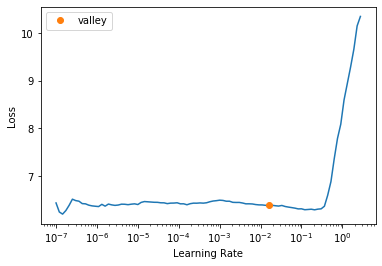

In [ ]:
path = untar_data(URLs.CIFAR_100)
print((path/'test').ls())
item_tfms = [ToTensor(), Resize(64)]
batch_tfms = [IntToFloatTensor()]


dls =  DataBlock(blocks=(ImageBlock(cls=PILImage), CategoryBlock),
                  get_items=get_image_files,
                  #splitter=GrandparentSplitter(train_name='train', valid_name='test'),
                  splitter=FuncSplitter(lambda o: Path(o).parent.parent.parent.name == 'test'),
                  get_y=parent_label,
                  item_tfms=item_tfms,
                  batch_tfms=batch_tfms
                 ).dataloaders(path, bs=32)

model=alexnet
learn=vision_learner(dls,model, pretrained=False, loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=SGD)
lr=learn.lr_find()
learn.fit_one_cycle(20, lr_max=lr)

epoch,train_loss,valid_loss,accuracy,time
0,6.440627,5.351104,0.011000,17:41
1,6.387400,5.308966,0.011600,17:53
2,6.377512,5.217277,0.013500,18:22
3,6.337202,5.151965,0.013900,19:37
4,6.175656,5.117057,0.016800,19:49


KeyboardInterrupt: 

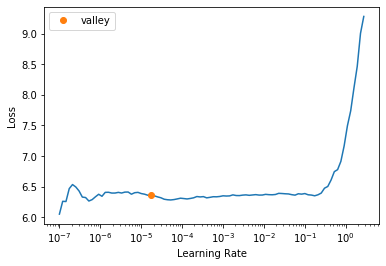

In [ ]:
path = untar_data(URLs.CIFAR_100)
print((path/'test').ls())
item_tfms = [ToTensor(), Resize(64)]
batch_tfms = [IntToFloatTensor()]


dls =  DataBlock(blocks=(ImageBlock(cls=PILImage), CategoryBlock),
                  get_items=get_image_files,
                  #splitter=GrandparentSplitter(train_name='train', valid_name='test'),
                  splitter=FuncSplitter(lambda o: Path(o).parent.parent.parent.name == 'test'),
                  get_y=parent_label,
                  item_tfms=item_tfms,
                  batch_tfms=batch_tfms
                 ).dataloaders(path, bs=32)

model=resnet18
learn=vision_learner(dls,model, pretrained=False, loss_func=CrossEntropyLossFlat(),metrics=accuracy, opt_func=SGD)
lr=learn.lr_find()
learn.fit_one_cycle(20, lr_max=lr)